In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d9]
test_output = [pro_s4d9]

In [20]:
train_input = train_input + val_input
train_output = train_output + val_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([66175, 13953])
torch.Size([28921, 13953])
torch.Size([459, 13953])
torch.Size([66175, 1])
torch.Size([28921, 1])
torch.Size([459, 1])


In [26]:
def top_samples(source, target, num):
    distances = LA.norm(source-target, axis=1)
    temp_list = []
    for i in range(len(distances)):
        temp_list.append([distances[i], i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [27]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(test_input.shape[0])):
    near_neig_ind = top_samples(test_input[i], train_input, 10)
    input_near_ind_list.append(train_input[near_neig_ind])
    output_near_ind_list.append(train_output[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 459/459 [14:21<00:00,  1.88s/it]


In [28]:
# with open(r"input_near_eucli.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_eucli.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [29]:
# with open(r"input_near_eucli.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_eucli.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [30]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [31]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [32]:
# input_near = input_near.float()
# output_near = output_near.float()

In [ ]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [ ]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [ ]:
# input_near = torch.from_numpy(input_near)
# output_near = torch.from_numpy(output_near)

In [ ]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

input_near = input_near.to(device)
output_near = output_near.to(device)

In [ ]:
input_feature = RNA_s1d1.shape[1]

In [ ]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [ ]:
PATH = 'No_norm_model_RNA_pro'

In [ ]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 1.7481467 s1d1:  1.8940814 s1d2:  2.0444617 s1d3:  1.8012469 s2d1: 0.7116967 s2d4: 1.33586 s2d5: 1.2691878 s3d1: 0.5214739 s3d6: 1.3196439 s3d7: 1.4618528 s4d1: 1.6838514 s4d8: 2.009103 s4d9: 1.1627973 test loss: 1.5502180699411494


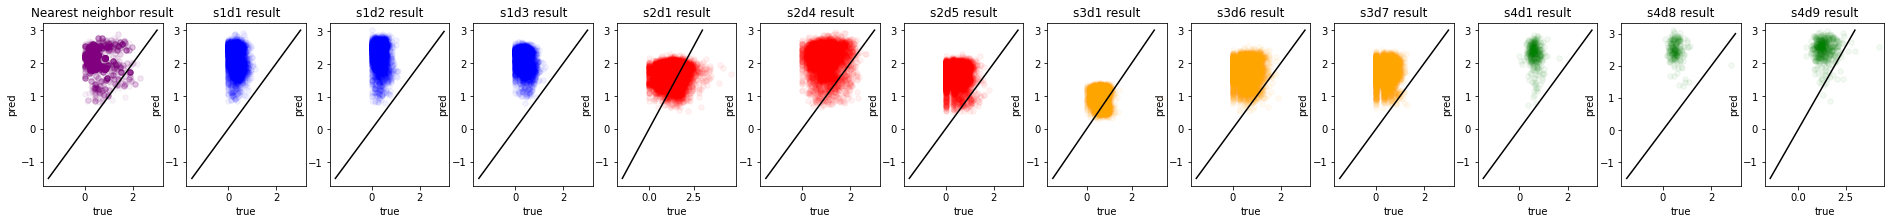

Epoch  100 near loss: 0.15269655 s1d1:  0.3077881 s1d2:  0.20749204 s1d3:  0.24614061 s2d1: 0.7850644 s2d4: 0.6272052 s2d5: 0.32305342 s3d1: 0.27484608 s3d6: 0.37448356 s3d7: 0.3062455 s4d1: 0.27077484 s4d8: 0.27697006 s4d9: 0.9320006 test loss: 0.662621267945168
Epoch  200 near loss: 0.074557535 s1d1:  0.29618734 s1d2:  0.20732896 s1d3:  0.24462572 s2d1: 0.7614765 s2d4: 0.5964976 s2d5: 0.3255523 s3d1: 0.29151818 s3d6: 0.37190604 s3d7: 0.30392322 s4d1: 0.26299426 s4d8: 0.27868354 s4d9: 0.9312113 test loss: 0.6612124461584254
Epoch  300 near loss: 0.048200205 s1d1:  0.29090765 s1d2:  0.20795691 s1d3:  0.24548195 s2d1: 0.74837834 s2d4: 0.5863374 s2d5: 0.32573864 s3d1: 0.28959873 s3d6: 0.36976686 s3d7: 0.30404288 s4d1: 0.26530227 s4d8: 0.2827765 s4d9: 0.94619787 test loss: 0.6715647532281934
Epoch  400 near loss: 0.044327233 s1d1:  0.31613368 s1d2:  0.2201399 s1d3:  0.2650471 s2d1: 0.72123677 s2d4: 0.5665375 s2d5: 0.33761388 s3d1: 0.29447138 s3d6: 0.3774754 s3d7: 0.3172622 s4d1: 0.2535825

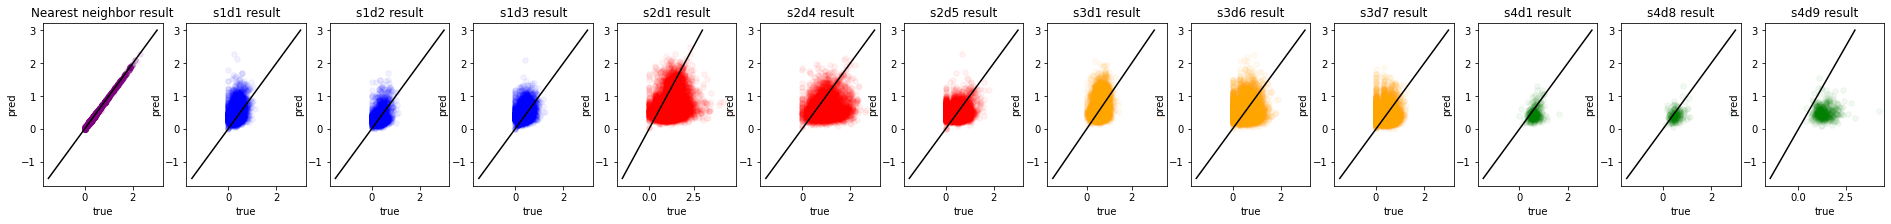

Epoch  1100 near loss: 0.020551885 s1d1:  0.31399122 s1d2:  0.22056736 s1d3:  0.26478413 s2d1: 0.7186239 s2d4: 0.56686527 s2d5: 0.3387774 s3d1: 0.2993642 s3d6: 0.37777096 s3d7: 0.3201487 s4d1: 0.26065382 s4d8: 0.27959168 s4d9: 0.93065965 test loss: 0.660625509468954
Epoch  1200 near loss: 0.015305847 s1d1:  0.29996789 s1d2:  0.2139492 s1d3:  0.2540068 s2d1: 0.7374793 s2d4: 0.58102024 s2d5: 0.32869166 s3d1: 0.29689103 s3d6: 0.3734639 s3d7: 0.31219643 s4d1: 0.27151012 s4d8: 0.28552875 s4d9: 0.9596832 test loss: 0.6813464427301318
Epoch  1300 near loss: 0.0119654 s1d1:  0.31177998 s1d2:  0.21918586 s1d3:  0.26288605 s2d1: 0.72416914 s2d4: 0.5714296 s2d5: 0.33537102 s3d1: 0.300532 s3d6: 0.37684825 s3d7: 0.31803837 s4d1: 0.2634554 s4d8: 0.28105083 s4d9: 0.93953925 test loss: 0.6668645054097349
Epoch  1400 near loss: 0.0077788597 s1d1:  0.30316964 s1d2:  0.21558467 s1d3:  0.2566542 s2d1: 0.7326938 s2d4: 0.5768029 s2d5: 0.3314208 s3d1: 0.29756516 s3d6: 0.37413684 s3d7: 0.31435007 s4d1: 0.2678

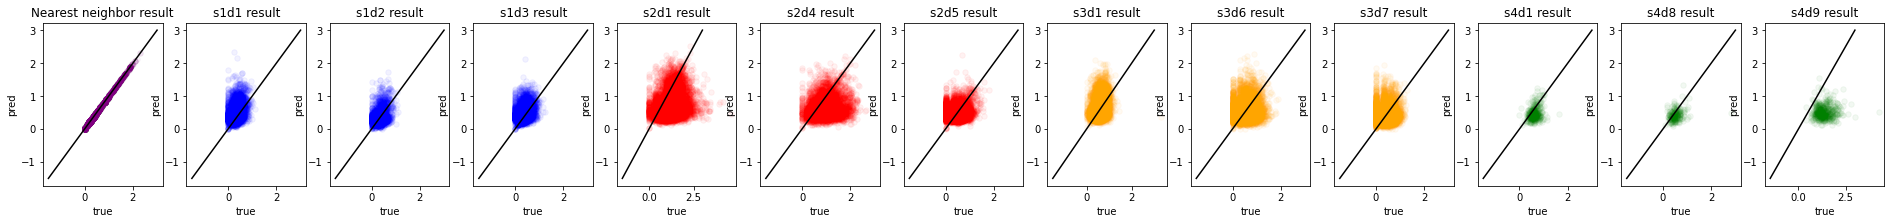

Epoch  2100 near loss: 0.0068669207 s1d1:  0.3010475 s1d2:  0.21509914 s1d3:  0.25567892 s2d1: 0.73047984 s2d4: 0.575231 s2d5: 0.33277997 s3d1: 0.29652032 s3d6: 0.37324607 s3d7: 0.31414035 s4d1: 0.26641187 s4d8: 0.28293994 s4d9: 0.9480676 test loss: 0.6729347014421694
Epoch  2200 near loss: 0.008701003 s1d1:  0.2999473 s1d2:  0.21449216 s1d3:  0.25472152 s2d1: 0.73404825 s2d4: 0.5786332 s2d5: 0.3303804 s3d1: 0.29848778 s3d6: 0.37347656 s3d7: 0.31356308 s4d1: 0.27026054 s4d8: 0.28550732 s4d9: 0.95628315 test loss: 0.6789803085714533
Epoch  2300 near loss: 0.015457697 s1d1:  0.29516658 s1d2:  0.21228781 s1d3:  0.2509982 s2d1: 0.7399745 s2d4: 0.58246934 s2d5: 0.32784867 s3d1: 0.2966901 s3d6: 0.3719751 s3d7: 0.31083426 s4d1: 0.27197814 s4d8: 0.28593522 s4d9: 0.9616548 test loss: 0.6827186515777216
Epoch  2400 near loss: 0.007553913 s1d1:  0.30390108 s1d2:  0.21688086 s1d3:  0.25815186 s2d1: 0.7275936 s2d4: 0.5736335 s2d5: 0.3344596 s3d1: 0.2990899 s3d6: 0.37477732 s3d7: 0.31579778 s4d1: 0.

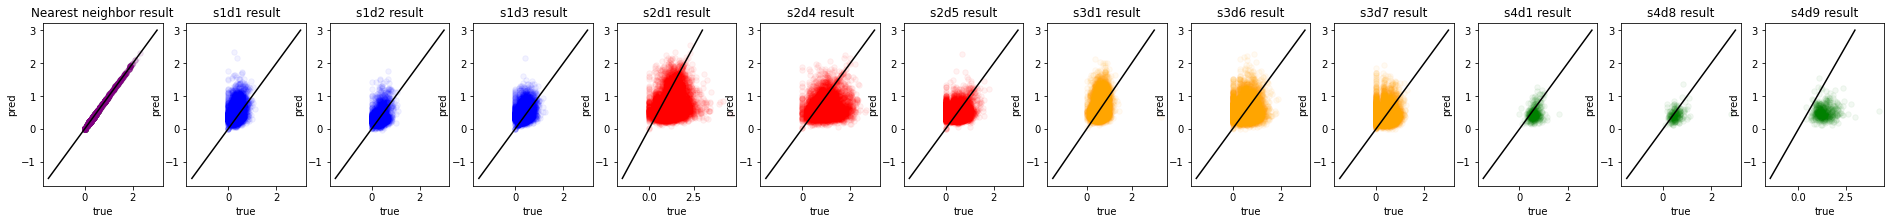

Epoch  3100 near loss: 0.01039908 s1d1:  0.30728754 s1d2:  0.21809971 s1d3:  0.26062453 s2d1: 0.7253118 s2d4: 0.5723566 s2d5: 0.33565962 s3d1: 0.30161718 s3d6: 0.37613004 s3d7: 0.31725392 s4d1: 0.26533628 s4d8: 0.28269708 s4d9: 0.9420907 test loss: 0.6689066940632277
Epoch  3200 near loss: 0.006287827 s1d1:  0.3004267 s1d2:  0.21486662 s1d3:  0.2553614 s2d1: 0.73301536 s2d4: 0.5773452 s2d5: 0.3311787 s3d1: 0.2989558 s3d6: 0.37383804 s3d7: 0.31382293 s4d1: 0.26931962 s4d8: 0.28469005 s4d9: 0.95304364 test loss: 0.6766898651361818
Epoch  3300 near loss: 0.013569126 s1d1:  0.30614176 s1d2:  0.21798824 s1d3:  0.26019442 s2d1: 0.7219436 s2d4: 0.5700611 s2d5: 0.33718246 s3d1: 0.30118495 s3d6: 0.3759118 s3d7: 0.3181149 s4d1: 0.2640081 s4d8: 0.28190428 s4d9: 0.93888307 test loss: 0.6665878389713504
Epoch  3400 near loss: 0.0048070555 s1d1:  0.30091837 s1d2:  0.21541749 s1d3:  0.2561099 s2d1: 0.7290668 s2d4: 0.575351 s2d5: 0.33323565 s3d1: 0.29974884 s3d6: 0.37418187 s3d7: 0.31471404 s4d1: 0.26

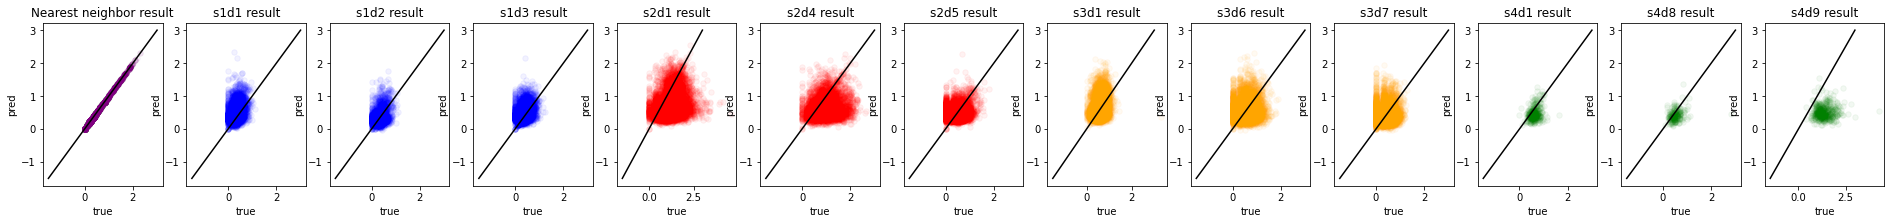

Epoch  4100 near loss: 0.005221255 s1d1:  0.3007645 s1d2:  0.21551871 s1d3:  0.25677326 s2d1: 0.7319177 s2d4: 0.57784665 s2d5: 0.33203134 s3d1: 0.30056942 s3d6: 0.3743127 s3d7: 0.31380028 s4d1: 0.26926416 s4d8: 0.28407064 s4d9: 0.95192873 test loss: 0.6759078574404659
Epoch  4200 near loss: 0.0070633553 s1d1:  0.29887465 s1d2:  0.21444191 s1d3:  0.25487703 s2d1: 0.7338392 s2d4: 0.5787097 s2d5: 0.33089986 s3d1: 0.29934615 s3d6: 0.3734495 s3d7: 0.3128192 s4d1: 0.26890212 s4d8: 0.28418887 s4d9: 0.9533284 test loss: 0.6767748943666653
Epoch  4300 near loss: 0.015717868 s1d1:  0.30795023 s1d2:  0.21839172 s1d3:  0.2618396 s2d1: 0.72137326 s2d4: 0.5698662 s2d5: 0.33782727 s3d1: 0.302467 s3d6: 0.37669116 s3d7: 0.31824407 s4d1: 0.2635964 s4d8: 0.2816245 s4d9: 0.93656397 test loss: 0.6650096280702413
Epoch  4400 near loss: 0.0037517848 s1d1:  0.3001592 s1d2:  0.21537508 s1d3:  0.25592098 s2d1: 0.7313331 s2d4: 0.5770492 s2d5: 0.33197898 s3d1: 0.30003372 s3d6: 0.3740485 s3d7: 0.31387812 s4d1: 0.2

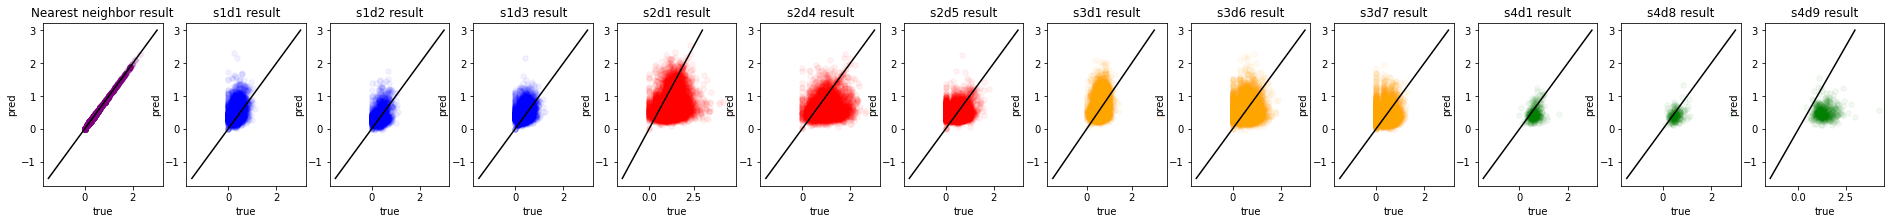

Epoch  5100 near loss: 0.009252762 s1d1:  0.2957918 s1d2:  0.21356565 s1d3:  0.25318485 s2d1: 0.73622453 s2d4: 0.58003235 s2d5: 0.3301872 s3d1: 0.29905042 s3d6: 0.37275302 s3d7: 0.3118728 s4d1: 0.27081892 s4d8: 0.28537515 s4d9: 0.95640796 test loss: 0.6791237892702321
Epoch  5200 near loss: 0.0059859077 s1d1:  0.2983322 s1d2:  0.21442226 s1d3:  0.25487304 s2d1: 0.73379153 s2d4: 0.57897145 s2d5: 0.33148128 s3d1: 0.29991406 s3d6: 0.37370315 s3d7: 0.31274804 s4d1: 0.2698145 s4d8: 0.28471637 s4d9: 0.9530122 test loss: 0.6767377040512343
Epoch  5300 near loss: 0.0077367094 s1d1:  0.29641688 s1d2:  0.21370412 s1d3:  0.2536182 s2d1: 0.7351825 s2d4: 0.57954484 s2d5: 0.3304884 s3d1: 0.29945046 s3d6: 0.3730208 s3d7: 0.31218898 s4d1: 0.2705997 s4d8: 0.2855324 s4d9: 0.9557389 test loss: 0.678675796120471
Epoch  5400 near loss: 0.0040781386 s1d1:  0.30073276 s1d2:  0.21573782 s1d3:  0.25704575 s2d1: 0.73073393 s2d4: 0.5760921 s2d5: 0.3326012 s3d1: 0.3009814 s3d6: 0.37400347 s3d7: 0.31422943 s4d1: 0

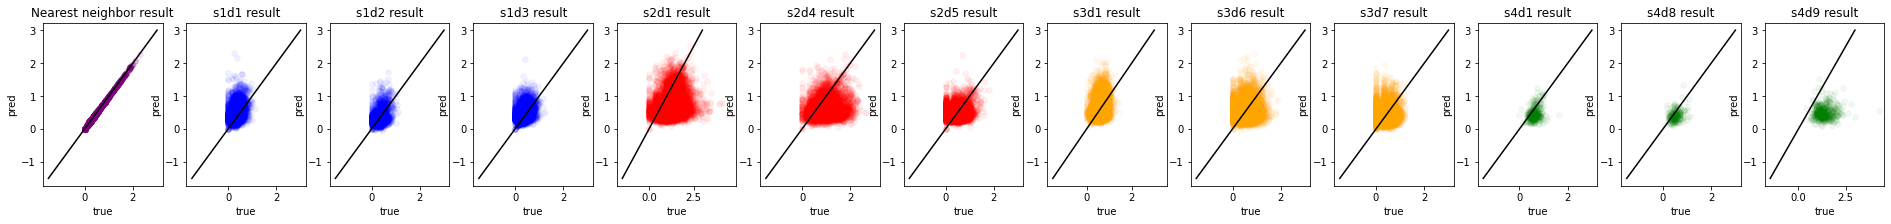

Epoch  6100 near loss: 0.003839659 s1d1:  0.29945892 s1d2:  0.21511513 s1d3:  0.25591287 s2d1: 0.7320033 s2d4: 0.5774284 s2d5: 0.33225816 s3d1: 0.30079418 s3d6: 0.3741089 s3d7: 0.31353128 s4d1: 0.26920325 s4d8: 0.28438744 s4d9: 0.950928 test loss: 0.6752804438711397
Epoch  6200 near loss: 0.012556901 s1d1:  0.29442793 s1d2:  0.21265535 s1d3:  0.25248197 s2d1: 0.73755544 s2d4: 0.58134717 s2d5: 0.32944196 s3d1: 0.29867116 s3d6: 0.3721343 s3d7: 0.31083587 s4d1: 0.27073544 s4d8: 0.28504014 s4d9: 0.95752704 test loss: 0.6798070066667066
Epoch  6300 near loss: 0.005120854 s1d1:  0.29764026 s1d2:  0.21417311 s1d3:  0.25475243 s2d1: 0.7326825 s2d4: 0.57824033 s2d5: 0.3320056 s3d1: 0.30009693 s3d6: 0.37358928 s3d7: 0.3128388 s4d1: 0.26897693 s4d8: 0.28369293 s4d9: 0.951423 test loss: 0.6755098548853431
Epoch  6400 near loss: 0.007473997 s1d1:  0.29782307 s1d2:  0.21443973 s1d3:  0.25518245 s2d1: 0.7355839 s2d4: 0.579632 s2d5: 0.33054128 s3d1: 0.30023172 s3d6: 0.37319848 s3d7: 0.31223154 s4d1: 0

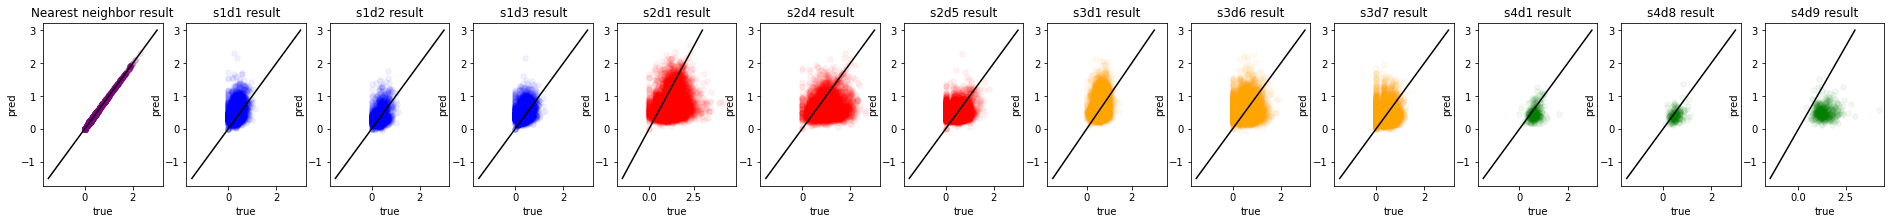

Epoch  7100 near loss: 0.0041564885 s1d1:  0.2994383 s1d2:  0.21544069 s1d3:  0.2565022 s2d1: 0.7320941 s2d4: 0.5774137 s2d5: 0.33272904 s3d1: 0.30138344 s3d6: 0.37398022 s3d7: 0.3136556 s4d1: 0.2691488 s4d8: 0.28433302 s4d9: 0.9507446 test loss: 0.6751499327178887
Epoch  7200 near loss: 0.0066405567 s1d1:  0.30375126 s1d2:  0.21671848 s1d3:  0.25937337 s2d1: 0.72750753 s2d4: 0.5738556 s2d5: 0.33470634 s3d1: 0.30236867 s3d6: 0.37499234 s3d7: 0.31505862 s4d1: 0.26580662 s4d8: 0.2821487 s4d9: 0.9431116 test loss: 0.669581131512499
Epoch  7300 near loss: 0.005812064 s1d1:  0.2991827 s1d2:  0.21492857 s1d3:  0.25574073 s2d1: 0.7347075 s2d4: 0.57866424 s2d5: 0.3314151 s3d1: 0.30080658 s3d6: 0.37360224 s3d7: 0.31288743 s4d1: 0.26954252 s4d8: 0.28407058 s4d9: 0.9519302 test loss: 0.6759458593809707
Epoch  7400 near loss: 0.006609998 s1d1:  0.29718867 s1d2:  0.21412511 s1d3:  0.25430843 s2d1: 0.7339043 s2d4: 0.5783168 s2d5: 0.33177108 s3d1: 0.2995701 s3d6: 0.37303436 s3d7: 0.3124215 s4d1: 0.26

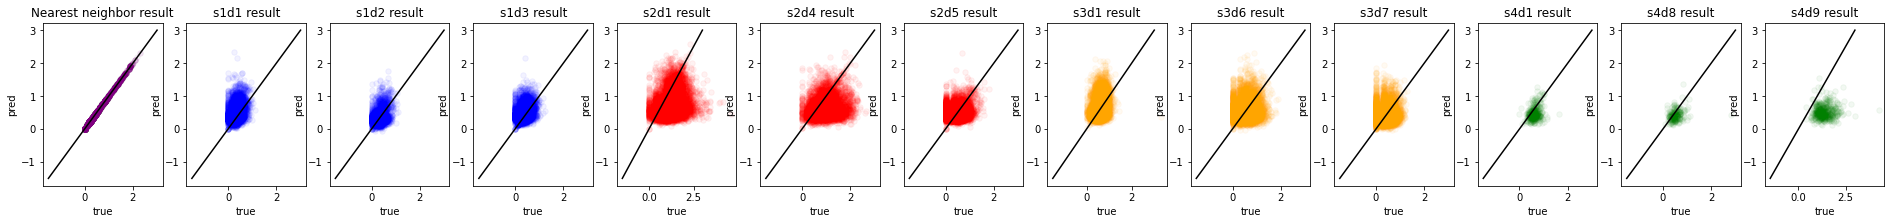

Epoch  8100 near loss: 0.006143153 s1d1:  0.2982354 s1d2:  0.2147045 s1d3:  0.25577173 s2d1: 0.73462105 s2d4: 0.57959723 s2d5: 0.3316254 s3d1: 0.30150095 s3d6: 0.37391704 s3d7: 0.31267685 s4d1: 0.27125022 s4d8: 0.2856379 s4d9: 0.9533055 test loss: 0.677199209954344
Epoch  8200 near loss: 0.0039595086 s1d1:  0.30341482 s1d2:  0.21678998 s1d3:  0.25953373 s2d1: 0.72882897 s2d4: 0.5752459 s2d5: 0.33416575 s3d1: 0.30272606 s3d6: 0.37495306 s3d7: 0.31472445 s4d1: 0.26802984 s4d8: 0.28337705 s4d9: 0.94567645 test loss: 0.67164178324794
Epoch  8300 near loss: 0.0038383817 s1d1:  0.30267987 s1d2:  0.21653019 s1d3:  0.25876695 s2d1: 0.732048 s2d4: 0.57702494 s2d5: 0.3328179 s3d1: 0.3033687 s3d6: 0.37514725 s3d7: 0.31415692 s4d1: 0.26924008 s4d8: 0.283675 s4d9: 0.9479078 test loss: 0.6732713066335333
Epoch  8400 near loss: 0.0035874043 s1d1:  0.30089015 s1d2:  0.21580552 s1d3:  0.25775218 s2d1: 0.7300583 s2d4: 0.5755277 s2d5: 0.3334411 s3d1: 0.30184424 s3d6: 0.37403795 s3d7: 0.3140287 s4d1: 0.26

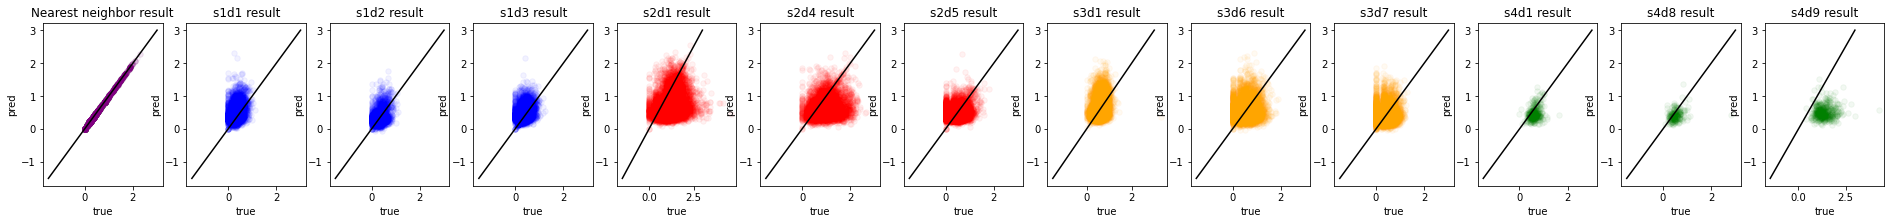

Epoch  9100 near loss: 0.003963544 s1d1:  0.30316764 s1d2:  0.21648987 s1d3:  0.25936353 s2d1: 0.731025 s2d4: 0.5763451 s2d5: 0.33339727 s3d1: 0.30395746 s3d6: 0.37529594 s3d7: 0.31445456 s4d1: 0.2688422 s4d8: 0.2834255 s4d9: 0.94663805 test loss: 0.6723758372046571
Epoch  9200 near loss: 0.0037861255 s1d1:  0.3028933 s1d2:  0.21685193 s1d3:  0.25944275 s2d1: 0.72997123 s2d4: 0.57607543 s2d5: 0.3341639 s3d1: 0.30369398 s3d6: 0.3754553 s3d7: 0.3147394 s4d1: 0.26868457 s4d8: 0.28365412 s4d9: 0.9461632 test loss: 0.6720678806066928
Epoch  9300 near loss: 0.010337282 s1d1:  0.29714972 s1d2:  0.21395288 s1d3:  0.25482136 s2d1: 0.735824 s2d4: 0.58045536 s2d5: 0.33075812 s3d1: 0.3012593 s3d6: 0.37324676 s3d7: 0.31183892 s4d1: 0.2712585 s4d8: 0.28501797 s4d9: 0.95464617 test loss: 0.6780126362650046
Epoch  9400 near loss: 0.006613716 s1d1:  0.30465594 s1d2:  0.21745439 s1d3:  0.26090607 s2d1: 0.7281091 s2d4: 0.57507825 s2d5: 0.33534384 s3d1: 0.3041744 s3d6: 0.3760049 s3d7: 0.31533203 s4d1: 0.2

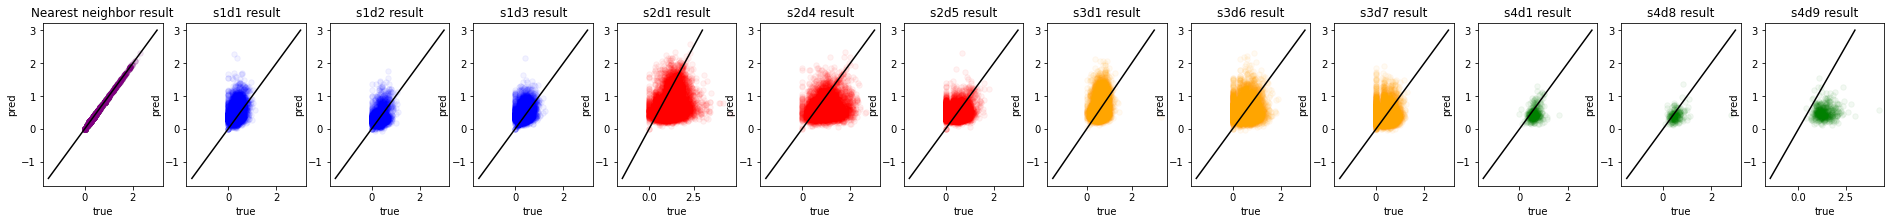

Epoch  10100 near loss: 0.0033552984 s1d1:  0.30002996 s1d2:  0.21535784 s1d3:  0.25758585 s2d1: 0.7312211 s2d4: 0.5770686 s2d5: 0.33347914 s3d1: 0.3020324 s3d6: 0.3740516 s3d7: 0.3134616 s4d1: 0.26858112 s4d8: 0.28351983 s4d9: 0.9470548 test loss: 0.6726185611640155
Epoch  10200 near loss: 0.008658651 s1d1:  0.3046977 s1d2:  0.21725535 s1d3:  0.2607107 s2d1: 0.7262643 s2d4: 0.5735213 s2d5: 0.33634457 s3d1: 0.3028384 s3d6: 0.3756049 s3d7: 0.3154819 s4d1: 0.26624963 s4d8: 0.28206143 s4d9: 0.939919 test loss: 0.6675687361303086
Epoch  10300 near loss: 0.004856992 s1d1:  0.29903355 s1d2:  0.21488555 s1d3:  0.25662506 s2d1: 0.73206323 s2d4: 0.5772753 s2d5: 0.33291894 s3d1: 0.3012173 s3d6: 0.37349486 s3d7: 0.31298202 s4d1: 0.26887956 s4d8: 0.28341997 s4d9: 0.9486022 test loss: 0.673649743443335
Epoch  10400 near loss: 0.0040001688 s1d1:  0.29896352 s1d2:  0.21472546 s1d3:  0.25649026 s2d1: 0.7327487 s2d4: 0.5774865 s2d5: 0.33263722 s3d1: 0.30134597 s3d6: 0.37363574 s3d7: 0.3128452 s4d1: 0.2

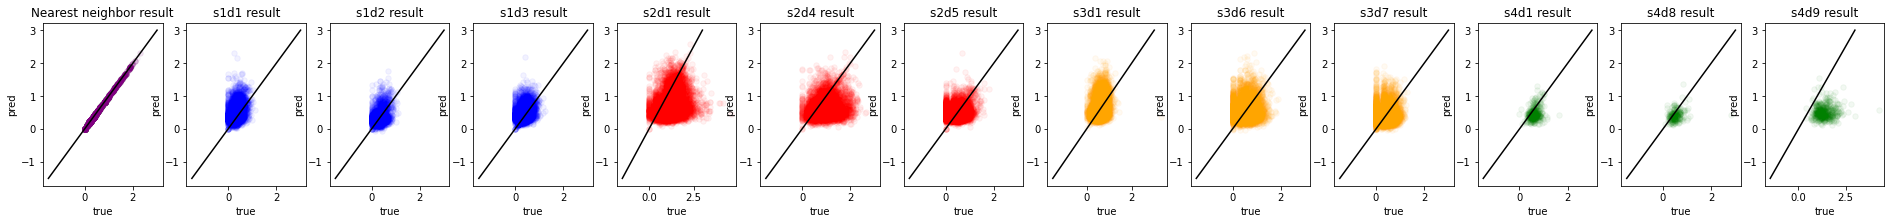

Epoch  11100 near loss: 0.006034255 s1d1:  0.2972383 s1d2:  0.21386395 s1d3:  0.25499573 s2d1: 0.7343005 s2d4: 0.57919633 s2d5: 0.332089 s3d1: 0.30103496 s3d6: 0.37318552 s3d7: 0.311997 s4d1: 0.26947272 s4d8: 0.28432977 s4d9: 0.95070636 test loss: 0.6751680679275751
Epoch  11200 near loss: 0.008773797 s1d1:  0.30563626 s1d2:  0.21785675 s1d3:  0.26169938 s2d1: 0.7259398 s2d4: 0.5727383 s2d5: 0.33617476 s3d1: 0.3042645 s3d6: 0.37562042 s3d7: 0.31586233 s4d1: 0.26581457 s4d8: 0.28145224 s4d9: 0.9386219 test loss: 0.6666192321603819
Epoch  11300 near loss: 0.003446197 s1d1:  0.3023717 s1d2:  0.21606217 s1d3:  0.25888854 s2d1: 0.730324 s2d4: 0.57624197 s2d5: 0.3338683 s3d1: 0.30274785 s3d6: 0.3746181 s3d7: 0.3138388 s4d1: 0.26790163 s4d8: 0.2827948 s4d9: 0.9445213 test loss: 0.6708273254920482
Epoch  11400 near loss: 0.00831934 s1d1:  0.29608235 s1d2:  0.21340054 s1d3:  0.25427556 s2d1: 0.73433626 s2d4: 0.57921267 s2d5: 0.33165947 s3d1: 0.3010631 s3d6: 0.37278008 s3d7: 0.31163812 s4d1: 0.2

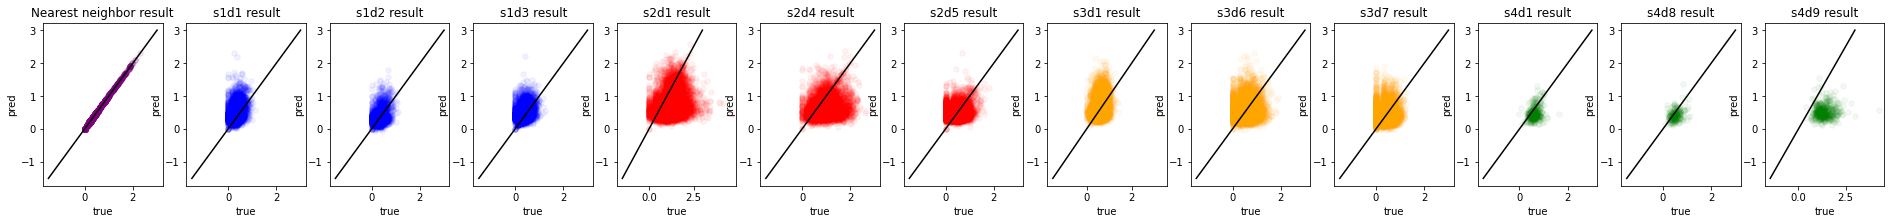

Epoch  12100 near loss: 0.0067613367 s1d1:  0.30324692 s1d2:  0.21672218 s1d3:  0.2599112 s2d1: 0.7255513 s2d4: 0.57344514 s2d5: 0.33680415 s3d1: 0.30301178 s3d6: 0.37510204 s3d7: 0.31528863 s4d1: 0.26586205 s4d8: 0.281944 s4d9: 0.9391193 test loss: 0.6669900229825243
Epoch  12200 near loss: 0.004159648 s1d1:  0.3008569 s1d2:  0.21526922 s1d3:  0.2577772 s2d1: 0.73263776 s2d4: 0.578194 s2d5: 0.3329586 s3d1: 0.30281487 s3d6: 0.37436613 s3d7: 0.3129471 s4d1: 0.26914677 s4d8: 0.28309864 s4d9: 0.9467103 test loss: 0.6724347184737337
Epoch  12300 near loss: 0.0037179298 s1d1:  0.299197 s1d2:  0.21483456 s1d3:  0.2565958 s2d1: 0.73148346 s2d4: 0.5771136 s2d5: 0.33332253 s3d1: 0.3017083 s3d6: 0.37360984 s3d7: 0.31292957 s4d1: 0.26859552 s4d8: 0.28288937 s4d9: 0.94664097 test loss: 0.6722980607091673
Epoch  12400 near loss: 0.0069488715 s1d1:  0.2995203 s1d2:  0.2147368 s1d3:  0.25659034 s2d1: 0.7338869 s2d4: 0.5792965 s2d5: 0.33208725 s3d1: 0.30220485 s3d6: 0.37379694 s3d7: 0.31239814 s4d1: 0

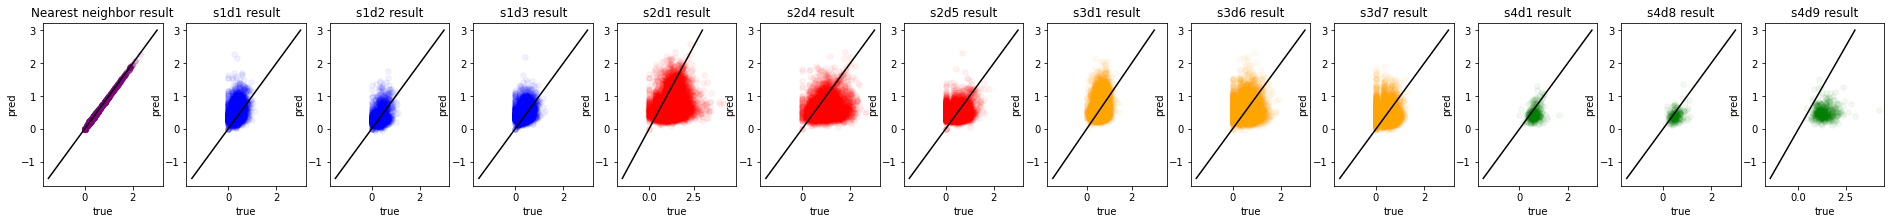

Epoch  13100 near loss: 0.0038460877 s1d1:  0.30221856 s1d2:  0.21597908 s1d3:  0.25892833 s2d1: 0.7293891 s2d4: 0.5759022 s2d5: 0.33443427 s3d1: 0.3025571 s3d6: 0.3746333 s3d7: 0.31379274 s4d1: 0.26788014 s4d8: 0.28267896 s4d9: 0.9431242 test loss: 0.669911477861827
Epoch  13200 near loss: 0.0034344343 s1d1:  0.30114707 s1d2:  0.21544196 s1d3:  0.25816178 s2d1: 0.7298963 s2d4: 0.5762346 s2d5: 0.33414963 s3d1: 0.3022147 s3d6: 0.3740441 s3d7: 0.31342447 s4d1: 0.26797843 s4d8: 0.2824984 s4d9: 0.9442122 test loss: 0.6706119459880161
Epoch  13300 near loss: 0.004107202 s1d1:  0.30245936 s1d2:  0.21628419 s1d3:  0.25939327 s2d1: 0.7285658 s2d4: 0.57556134 s2d5: 0.33498868 s3d1: 0.30327234 s3d6: 0.3748303 s3d7: 0.31434366 s4d1: 0.26773605 s4d8: 0.28239524 s4d9: 0.9424406 test loss: 0.6694257426229309
Epoch  13400 near loss: 0.0049138046 s1d1:  0.29915246 s1d2:  0.21476738 s1d3:  0.25655982 s2d1: 0.73338675 s2d4: 0.57892084 s2d5: 0.33258083 s3d1: 0.30250475 s3d6: 0.3740784 s3d7: 0.3124918 s4d

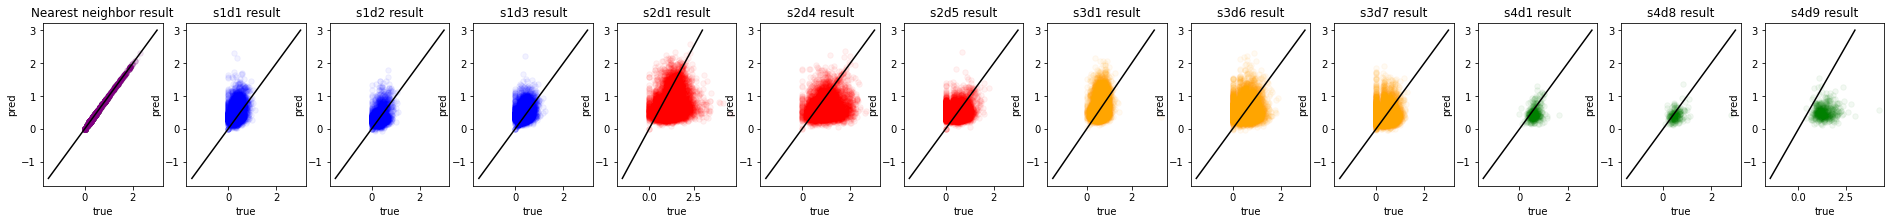

Epoch  14100 near loss: 0.003957425 s1d1:  0.29883966 s1d2:  0.21485724 s1d3:  0.25649467 s2d1: 0.7317266 s2d4: 0.57809037 s2d5: 0.33333507 s3d1: 0.30164382 s3d6: 0.3739269 s3d7: 0.3126286 s4d1: 0.26914814 s4d8: 0.28338894 s4d9: 0.946795 test loss: 0.6725149321393986
Epoch  14200 near loss: 0.0029561867 s1d1:  0.3019228 s1d2:  0.21604243 s1d3:  0.2589014 s2d1: 0.7309068 s2d4: 0.57777566 s2d5: 0.33367845 s3d1: 0.3036269 s3d6: 0.37518746 s3d7: 0.3137405 s4d1: 0.2699599 s4d8: 0.28389755 s4d9: 0.94640255 test loss: 0.6724144765607089
Epoch  14300 near loss: 0.002945501 s1d1:  0.30103478 s1d2:  0.21575686 s1d3:  0.25843638 s2d1: 0.73018444 s2d4: 0.57725286 s2d5: 0.33408597 s3d1: 0.30265424 s3d6: 0.3744226 s3d7: 0.31346005 s4d1: 0.26872587 s4d8: 0.2828972 s4d9: 0.94528836 test loss: 0.6714420177532676
Epoch  14400 near loss: 0.0026155678 s1d1:  0.30017564 s1d2:  0.21546146 s1d3:  0.25759238 s2d1: 0.7312296 s2d4: 0.577576 s2d5: 0.33382228 s3d1: 0.3024691 s3d6: 0.37461177 s3d7: 0.3131834 s4d1:

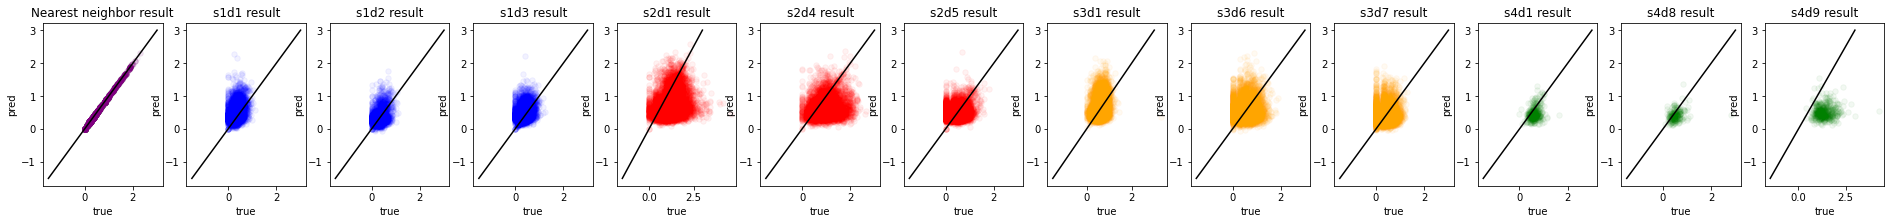

Epoch  15100 near loss: 0.006226029 s1d1:  0.29803568 s1d2:  0.21385823 s1d3:  0.25535586 s2d1: 0.73357594 s2d4: 0.57993585 s2d5: 0.33224586 s3d1: 0.3023274 s3d6: 0.3740734 s3d7: 0.3121756 s4d1: 0.27089015 s4d8: 0.2841577 s4d9: 0.9505454 test loss: 0.6752384771729785
Epoch  15200 near loss: 0.005548226 s1d1:  0.29905558 s1d2:  0.2145614 s1d3:  0.25661862 s2d1: 0.73263407 s2d4: 0.5790112 s2d5: 0.33265057 s3d1: 0.30268744 s3d6: 0.37429824 s3d7: 0.3124985 s4d1: 0.27086842 s4d8: 0.28419104 s4d9: 0.9491447 test loss: 0.6743335102406423
Epoch  15300 near loss: 0.0034742772 s1d1:  0.30076468 s1d2:  0.2154526 s1d3:  0.25828964 s2d1: 0.7314093 s2d4: 0.57747734 s2d5: 0.33328623 s3d1: 0.3021255 s3d6: 0.37418348 s3d7: 0.31283095 s4d1: 0.26923442 s4d8: 0.28290528 s4d9: 0.945223 test loss: 0.6714685115693506
Epoch  15400 near loss: 0.0027909733 s1d1:  0.30270275 s1d2:  0.21639751 s1d3:  0.25981787 s2d1: 0.7286746 s2d4: 0.57600915 s2d5: 0.33469248 s3d1: 0.3035472 s3d6: 0.37508535 s3d7: 0.31398717 s4d

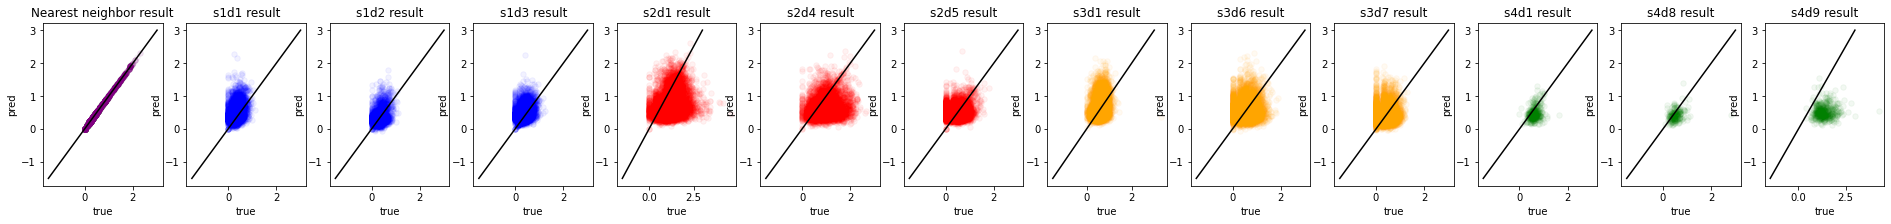

Epoch  16100 near loss: 0.0042779855 s1d1:  0.30123937 s1d2:  0.21565159 s1d3:  0.2586809 s2d1: 0.7276298 s2d4: 0.57529384 s2d5: 0.33541355 s3d1: 0.3026852 s3d6: 0.37463492 s3d7: 0.31375223 s4d1: 0.26725465 s4d8: 0.28178242 s4d9: 0.9412439 test loss: 0.6685346186927511
Epoch  16200 near loss: 0.0028899296 s1d1:  0.30201343 s1d2:  0.21622172 s1d3:  0.2595355 s2d1: 0.7287868 s2d4: 0.57621616 s2d5: 0.334827 s3d1: 0.3026572 s3d6: 0.3747301 s3d7: 0.3136144 s4d1: 0.26828918 s4d8: 0.2822831 s4d9: 0.942086 test loss: 0.6692607649473805
Epoch  16300 near loss: 0.004074383 s1d1:  0.30113888 s1d2:  0.21564917 s1d3:  0.2587259 s2d1: 0.72794193 s2d4: 0.57557106 s2d5: 0.33507666 s3d1: 0.30267614 s3d6: 0.37447974 s3d7: 0.31348816 s4d1: 0.26728293 s4d8: 0.28194806 s4d9: 0.94110286 test loss: 0.6684617116303083
Epoch  16400 near loss: 0.0035201004 s1d1:  0.30129832 s1d2:  0.21543811 s1d3:  0.25862956 s2d1: 0.728581 s2d4: 0.5762839 s2d5: 0.33495322 s3d1: 0.30251494 s3d6: 0.37459606 s3d7: 0.31341708 s4d1

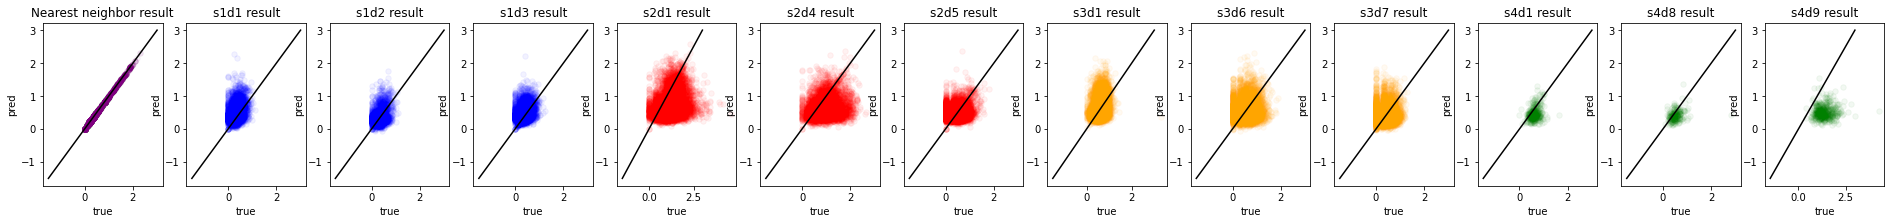

Epoch  17100 near loss: 0.0029080997 s1d1:  0.29982352 s1d2:  0.21511011 s1d3:  0.25799465 s2d1: 0.7301888 s2d4: 0.5772412 s2d5: 0.33398902 s3d1: 0.3021461 s3d6: 0.37405568 s3d7: 0.31274912 s4d1: 0.2692633 s4d8: 0.28306067 s4d9: 0.9455439 test loss: 0.6716932859039801
Epoch  17200 near loss: 0.0033843238 s1d1:  0.3002938 s1d2:  0.215188 s1d3:  0.25830752 s2d1: 0.72973317 s2d4: 0.5764688 s2d5: 0.3339293 s3d1: 0.3018699 s3d6: 0.37379107 s3d7: 0.312752 s4d1: 0.26800612 s4d8: 0.28201845 s4d9: 0.9433247 test loss: 0.6700002582615383
Epoch  17300 near loss: 0.0026356117 s1d1:  0.3015727 s1d2:  0.21565334 s1d3:  0.25891706 s2d1: 0.7297274 s2d4: 0.5768146 s2d5: 0.33414966 s3d1: 0.30257747 s3d6: 0.37446433 s3d7: 0.31314105 s4d1: 0.268644 s4d8: 0.28241366 s4d9: 0.943271 test loss: 0.6700853280999779
Epoch  17400 near loss: 0.0026151978 s1d1:  0.2998657 s1d2:  0.2152297 s1d3:  0.25783658 s2d1: 0.73001754 s2d4: 0.5769777 s2d5: 0.3340034 s3d1: 0.30193576 s3d6: 0.3741458 s3d7: 0.312752 s4d1: 0.26878

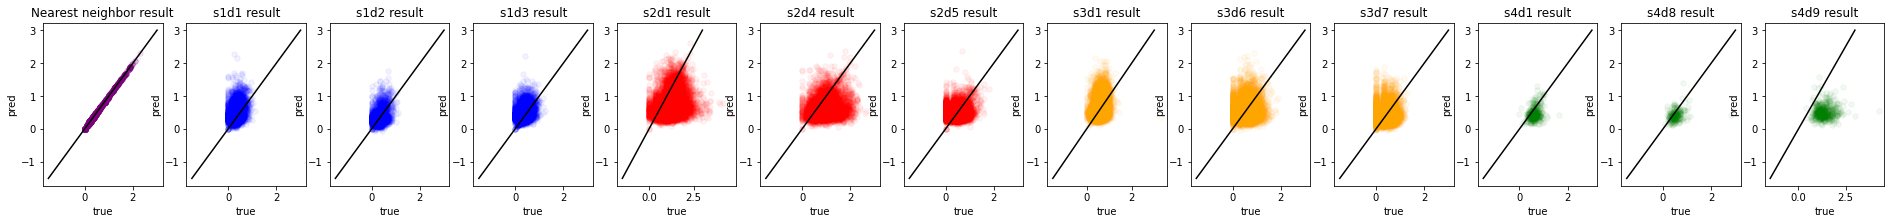

Epoch  18100 near loss: 0.0034771154 s1d1:  0.3016187 s1d2:  0.21556202 s1d3:  0.25899655 s2d1: 0.7300956 s2d4: 0.5775846 s2d5: 0.33364698 s3d1: 0.30353045 s3d6: 0.3748918 s3d7: 0.31317386 s4d1: 0.26965052 s4d8: 0.28295624 s4d9: 0.94517934 test loss: 0.6715005484226009
Epoch  18200 near loss: 0.003677478 s1d1:  0.29967418 s1d2:  0.21511512 s1d3:  0.25775564 s2d1: 0.7312623 s2d4: 0.5777533 s2d5: 0.3332988 s3d1: 0.3022252 s3d6: 0.37388635 s3d7: 0.3123061 s4d1: 0.2688775 s4d8: 0.2823233 s4d9: 0.94516885 test loss: 0.6713350680704842
Epoch  18300 near loss: 0.0035150312 s1d1:  0.29880264 s1d2:  0.2147 s1d3:  0.2571655 s2d1: 0.7309771 s2d4: 0.5772473 s2d5: 0.33353433 s3d1: 0.30140445 s3d6: 0.37363777 s3d7: 0.31230888 s4d1: 0.26895452 s4d8: 0.2828537 s4d9: 0.945594 test loss: 0.6716663184780819
Epoch  18400 near loss: 0.003917372 s1d1:  0.29978412 s1d2:  0.21502922 s1d3:  0.25794712 s2d1: 0.7307263 s2d4: 0.5777459 s2d5: 0.33344403 s3d1: 0.3026688 s3d6: 0.374123 s3d7: 0.312693 s4d1: 0.2693731

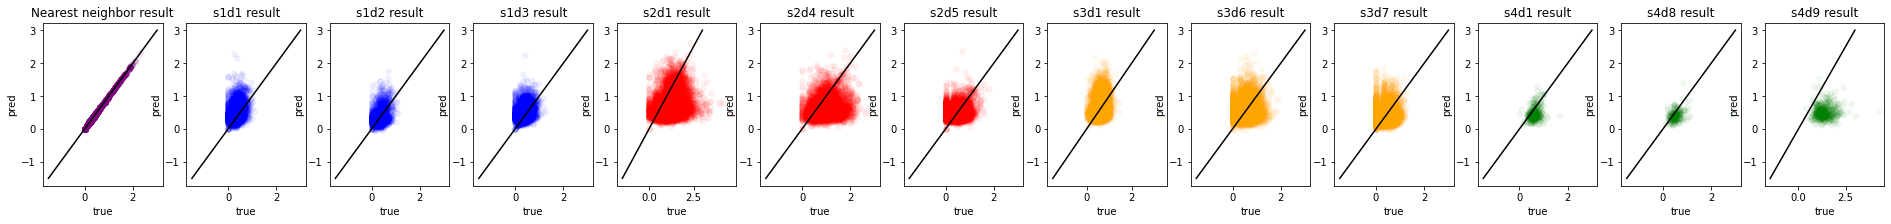

Epoch  19100 near loss: 0.002370549 s1d1:  0.29995635 s1d2:  0.21503012 s1d3:  0.25820792 s2d1: 0.72918653 s2d4: 0.57662517 s2d5: 0.33420524 s3d1: 0.3017321 s3d6: 0.37408432 s3d7: 0.31266174 s4d1: 0.2688008 s4d8: 0.28264973 s4d9: 0.94404507 test loss: 0.6706270868248037
Epoch  19200 near loss: 0.0025404561 s1d1:  0.3007312 s1d2:  0.21548319 s1d3:  0.2589078 s2d1: 0.7287196 s2d4: 0.5768972 s2d5: 0.33438691 s3d1: 0.302972 s3d6: 0.3745857 s3d7: 0.31301397 s4d1: 0.26881316 s4d8: 0.28261822 s4d9: 0.9439422 test loss: 0.6705595140167119
Epoch  19300 near loss: 0.006166086 s1d1:  0.30350435 s1d2:  0.21666776 s1d3:  0.26088578 s2d1: 0.7263966 s2d4: 0.5747501 s2d5: 0.33559215 s3d1: 0.3034129 s3d6: 0.3753289 s3d7: 0.31402728 s4d1: 0.26708308 s4d8: 0.28147754 s4d9: 0.93899965 test loss: 0.6670348731215321
Epoch  19400 near loss: 0.0026792528 s1d1:  0.2994573 s1d2:  0.21482666 s1d3:  0.25774598 s2d1: 0.72981334 s2d4: 0.5771475 s2d5: 0.33393973 s3d1: 0.3018724 s3d6: 0.37405127 s3d7: 0.3124117 s4d1:

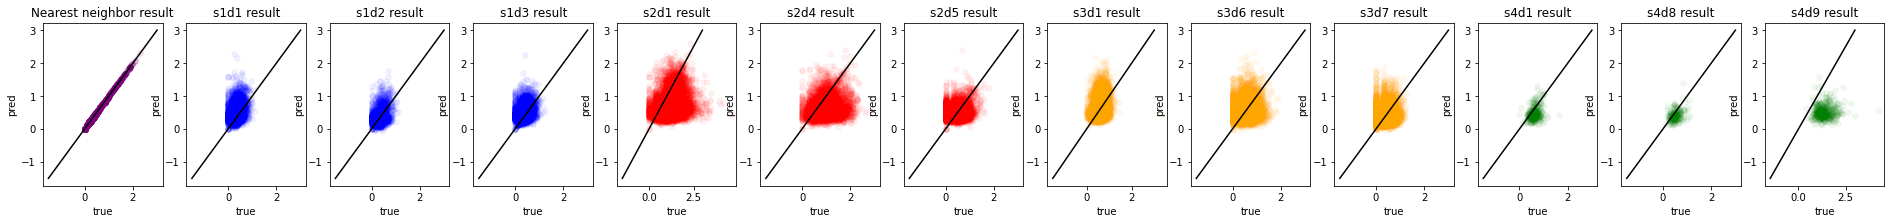

Epoch  20100 near loss: 0.0032929466 s1d1:  0.29973885 s1d2:  0.21480066 s1d3:  0.2578285 s2d1: 0.729658 s2d4: 0.57754266 s2d5: 0.33374134 s3d1: 0.30219898 s3d6: 0.37410772 s3d7: 0.3125068 s4d1: 0.26920983 s4d8: 0.28292346 s4d9: 0.9452147 test loss: 0.6714614671857324
Epoch  20200 near loss: 0.0030107677 s1d1:  0.29983845 s1d2:  0.2148434 s1d3:  0.25815162 s2d1: 0.7294531 s2d4: 0.57758325 s2d5: 0.33419132 s3d1: 0.30220166 s3d6: 0.37420526 s3d7: 0.312542 s4d1: 0.26865628 s4d8: 0.2824349 s4d9: 0.9444804 test loss: 0.6708703116528001
Epoch  20300 near loss: 0.0042022043 s1d1:  0.30183727 s1d2:  0.21606107 s1d3:  0.25999352 s2d1: 0.72768134 s2d4: 0.57623816 s2d5: 0.33555996 s3d1: 0.30329525 s3d6: 0.3753596 s3d7: 0.31367987 s4d1: 0.2685966 s4d8: 0.2827582 s4d9: 0.94159466 test loss: 0.6690260620998945
Epoch  20400 near loss: 0.007502412 s1d1:  0.30336422 s1d2:  0.21673445 s1d3:  0.26099807 s2d1: 0.72558814 s2d4: 0.574381 s2d5: 0.33612007 s3d1: 0.3033434 s3d6: 0.37559596 s3d7: 0.3141735 s4d1

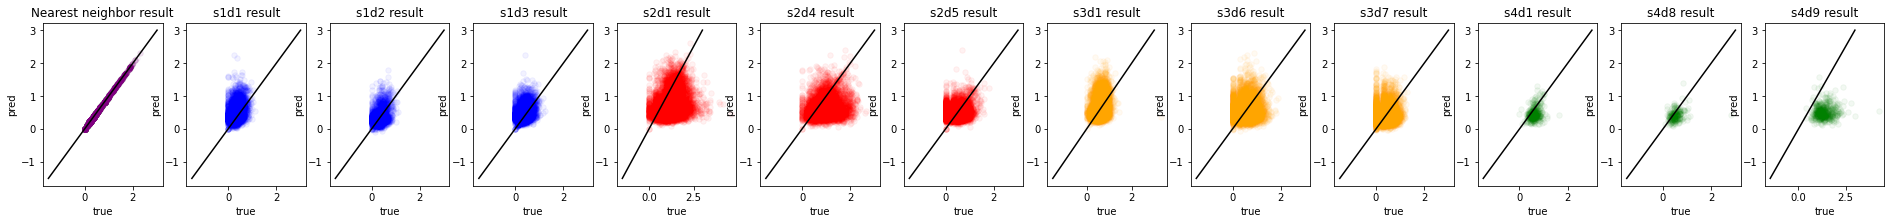

Epoch  21100 near loss: 0.0033219531 s1d1:  0.29974395 s1d2:  0.21472053 s1d3:  0.2579487 s2d1: 0.7301792 s2d4: 0.57796776 s2d5: 0.33396757 s3d1: 0.3016134 s3d6: 0.37419903 s3d7: 0.312338 s4d1: 0.26919553 s4d8: 0.282503 s4d9: 0.9442811 test loss: 0.6708196590320219
Epoch  21200 near loss: 0.0045104623 s1d1:  0.298009 s1d2:  0.21421853 s1d3:  0.2570214 s2d1: 0.7307101 s2d4: 0.57869184 s2d5: 0.3336781 s3d1: 0.30187884 s3d6: 0.37393686 s3d7: 0.31198344 s4d1: 0.27011964 s4d8: 0.28383097 s4d9: 0.9468236 test loss: 0.6727020769037777
Epoch  21300 near loss: 0.0081271 s1d1:  0.2961658 s1d2:  0.21329413 s1d3:  0.2556483 s2d1: 0.7332886 s2d4: 0.5801661 s2d5: 0.33204117 s3d1: 0.30093896 s3d6: 0.37301722 s3d7: 0.3109124 s4d1: 0.27057207 s4d8: 0.2836508 s4d9: 0.9495738 test loss: 0.6745239425983093
Epoch  21400 near loss: 0.00527522 s1d1:  0.298386 s1d2:  0.21437919 s1d3:  0.25745657 s2d1: 0.73218113 s2d4: 0.579262 s2d5: 0.33268905 s3d1: 0.30206376 s3d6: 0.37380388 s3d7: 0.31165776 s4d1: 0.2702964

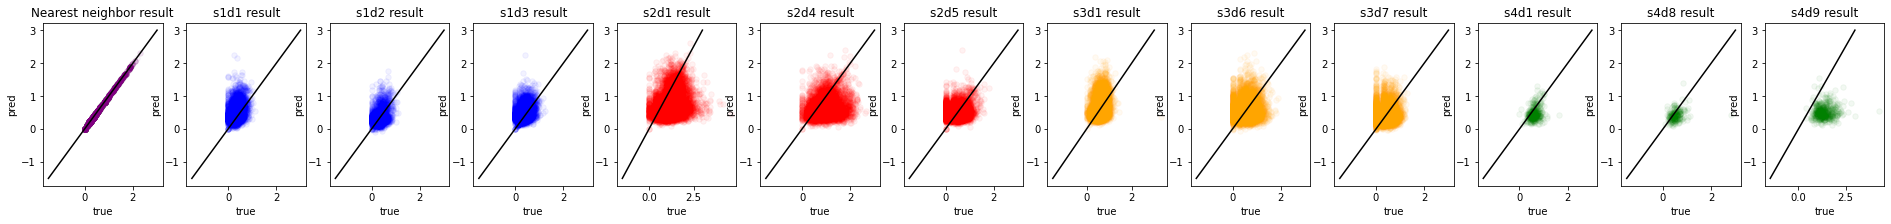

Epoch  22100 near loss: 0.0034705522 s1d1:  0.30013967 s1d2:  0.21494351 s1d3:  0.2586455 s2d1: 0.72992927 s2d4: 0.5777866 s2d5: 0.33356446 s3d1: 0.30262738 s3d6: 0.37427223 s3d7: 0.31247893 s4d1: 0.26964724 s4d8: 0.2828091 s4d9: 0.9451174 test loss: 0.6714472673392009
Epoch  22200 near loss: 0.0072629047 s1d1:  0.2960426 s1d2:  0.21355766 s1d3:  0.25558355 s2d1: 0.7336706 s2d4: 0.5803575 s2d5: 0.33214733 s3d1: 0.3004739 s3d6: 0.37324804 s3d7: 0.3109892 s4d1: 0.27119356 s4d8: 0.2842051 s4d9: 0.9495734 test loss: 0.6746553277973659
Epoch  22300 near loss: 0.0026092767 s1d1:  0.30037808 s1d2:  0.21528772 s1d3:  0.2589371 s2d1: 0.72933036 s2d4: 0.5772684 s2d5: 0.3341551 s3d1: 0.30212176 s3d6: 0.3741839 s3d7: 0.3125628 s4d1: 0.26864845 s4d8: 0.28197092 s4d9: 0.9429859 test loss: 0.6698631128224801
Epoch  22400 near loss: 0.003508944 s1d1:  0.29993638 s1d2:  0.21485516 s1d3:  0.25843102 s2d1: 0.7288298 s2d4: 0.5769556 s2d5: 0.3341194 s3d1: 0.30199 s3d6: 0.37409642 s3d7: 0.31249404 s4d1: 0.2

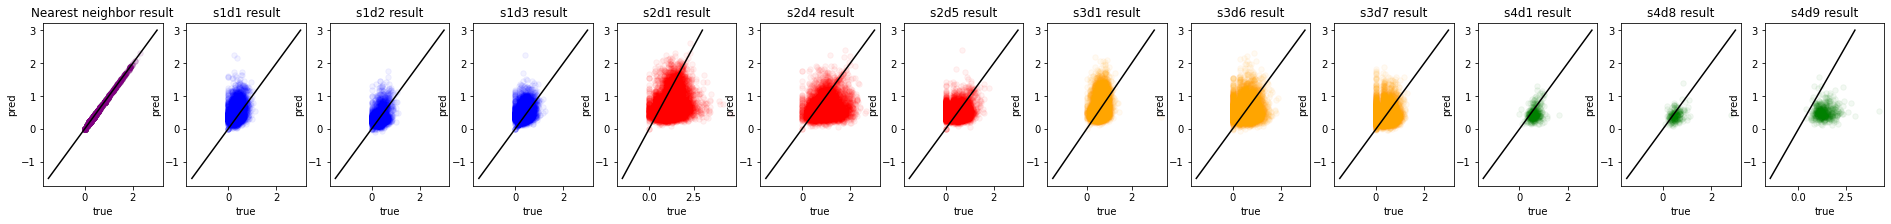

Epoch  23100 near loss: 0.004427323 s1d1:  0.3017691 s1d2:  0.21593893 s1d3:  0.2600877 s2d1: 0.7265157 s2d4: 0.5752227 s2d5: 0.33556756 s3d1: 0.30262926 s3d6: 0.37480375 s3d7: 0.31348166 s4d1: 0.26746404 s4d8: 0.28159204 s4d9: 0.9397386 test loss: 0.6675732641059864
Epoch  23200 near loss: 0.0028936663 s1d1:  0.2992192 s1d2:  0.21474347 s1d3:  0.25789538 s2d1: 0.7304956 s2d4: 0.57835627 s2d5: 0.33381996 s3d1: 0.30168816 s3d6: 0.37426445 s3d7: 0.31231225 s4d1: 0.26955786 s4d8: 0.28300777 s4d9: 0.9446351 test loss: 0.6711409977033594
Epoch  23300 near loss: 0.0033365283 s1d1:  0.30223382 s1d2:  0.21611586 s1d3:  0.2604636 s2d1: 0.727881 s2d4: 0.5768705 s2d5: 0.3353061 s3d1: 0.30299282 s3d6: 0.37523666 s3d7: 0.31359246 s4d1: 0.26892772 s4d8: 0.28232318 s4d9: 0.941653 test loss: 0.6690701647503858
Epoch  23400 near loss: 0.0028490387 s1d1:  0.29960975 s1d2:  0.21488853 s1d3:  0.25863552 s2d1: 0.72952265 s2d4: 0.5777738 s2d5: 0.33416307 s3d1: 0.30160052 s3d6: 0.3741804 s3d7: 0.31241477 s4d

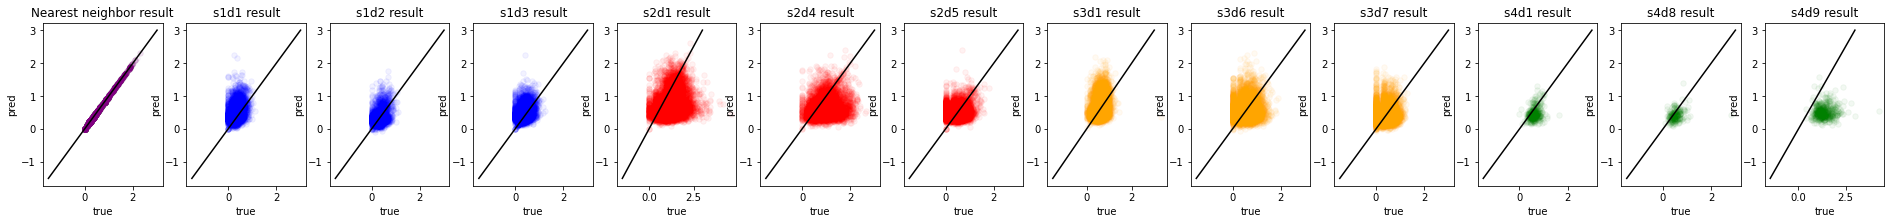

Epoch  24100 near loss: 0.0047704214 s1d1:  0.2993464 s1d2:  0.21462806 s1d3:  0.25816134 s2d1: 0.73075545 s2d4: 0.57850003 s2d5: 0.333303 s3d1: 0.30176362 s3d6: 0.37400007 s3d7: 0.3120745 s4d1: 0.27010503 s4d8: 0.28323683 s4d9: 0.94581693 test loss: 0.6719979310850474
Epoch  24200 near loss: 0.0065529533 s1d1:  0.2979336 s1d2:  0.21426977 s1d3:  0.25736684 s2d1: 0.73170906 s2d4: 0.5790736 s2d5: 0.33285654 s3d1: 0.30128756 s3d6: 0.37354413 s3d7: 0.31146914 s4d1: 0.2700962 s4d8: 0.28328678 s4d9: 0.94693327 test loss: 0.6727223196656179
Epoch  24300 near loss: 0.0029006572 s1d1:  0.30192384 s1d2:  0.21583658 s1d3:  0.26023057 s2d1: 0.72701705 s2d4: 0.57619745 s2d5: 0.33531606 s3d1: 0.30263117 s3d6: 0.37506214 s3d7: 0.31336775 s4d1: 0.26849598 s4d8: 0.2822897 s4d9: 0.94138217 test loss: 0.6688343352713582
Epoch  24400 near loss: 0.0051523303 s1d1:  0.29830986 s1d2:  0.21435152 s1d3:  0.25769904 s2d1: 0.7309584 s2d4: 0.57852 s2d5: 0.33340067 s3d1: 0.3012228 s3d6: 0.37361002 s3d7: 0.3116998

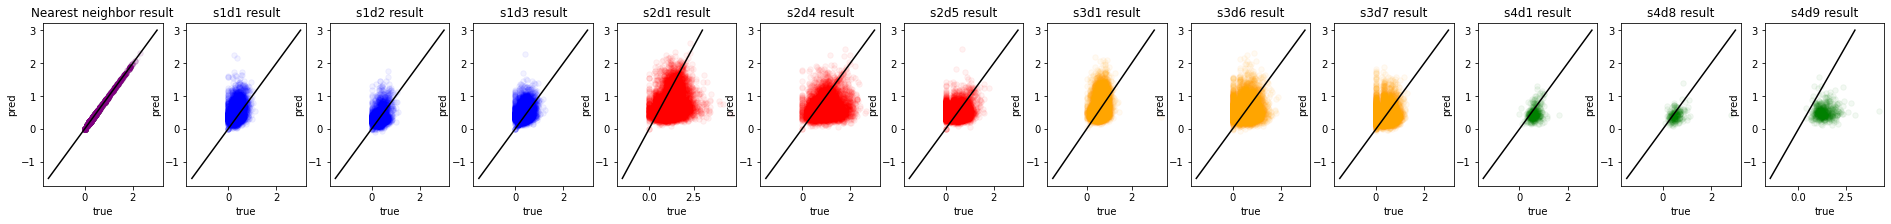

Epoch  25100 near loss: 0.0038159823 s1d1:  0.30226094 s1d2:  0.21600017 s1d3:  0.26051995 s2d1: 0.72760504 s2d4: 0.5767232 s2d5: 0.33538985 s3d1: 0.30307302 s3d6: 0.3754035 s3d7: 0.3134149 s4d1: 0.269236 s4d8: 0.28253624 s4d9: 0.94128114 test loss: 0.6688899766853404
Epoch  25200 near loss: 0.0077711255 s1d1:  0.29784212 s1d2:  0.21400902 s1d3:  0.25717586 s2d1: 0.73227066 s2d4: 0.5803671 s2d5: 0.33275738 s3d1: 0.3016029 s3d6: 0.37386233 s3d7: 0.31134328 s4d1: 0.2706905 s4d8: 0.28348482 s4d9: 0.9478542 test loss: 0.6734143165251026
Epoch  25300 near loss: 0.0055835987 s1d1:  0.29849756 s1d2:  0.21461953 s1d3:  0.25795022 s2d1: 0.73178524 s2d4: 0.5794154 s2d5: 0.3331128 s3d1: 0.301509 s3d6: 0.3737656 s3d7: 0.31166333 s4d1: 0.27047995 s4d8: 0.2837082 s4d9: 0.9467827 test loss: 0.6727132992250058
Epoch  25400 near loss: 0.0028166156 s1d1:  0.30002972 s1d2:  0.21496324 s1d3:  0.25877687 s2d1: 0.72986114 s2d4: 0.5784419 s2d5: 0.3338654 s3d1: 0.30248263 s3d6: 0.3747567 s3d7: 0.31243074 s4d1

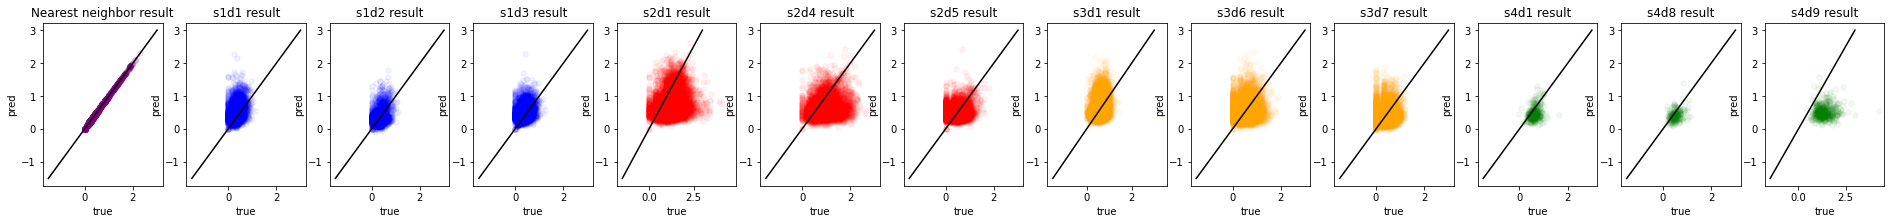

Epoch  26100 near loss: 0.004156322 s1d1:  0.29862854 s1d2:  0.21439528 s1d3:  0.2580834 s2d1: 0.73066604 s2d4: 0.57887226 s2d5: 0.33348313 s3d1: 0.3013449 s3d6: 0.37392038 s3d7: 0.31177416 s4d1: 0.26974353 s4d8: 0.2833614 s4d9: 0.94540435 test loss: 0.6716937528703244
Epoch  26200 near loss: 0.0022630661 s1d1:  0.3010358 s1d2:  0.2154585 s1d3:  0.26004657 s2d1: 0.7280276 s2d4: 0.5768926 s2d5: 0.33487305 s3d1: 0.3021077 s3d6: 0.3745419 s3d7: 0.3128413 s4d1: 0.26855528 s4d8: 0.28253868 s4d9: 0.9420356 test loss: 0.6692861974705382
Epoch  26300 near loss: 0.0032882171 s1d1:  0.30123875 s1d2:  0.21553278 s1d3:  0.26010245 s2d1: 0.7274545 s2d4: 0.57648575 s2d5: 0.3348906 s3d1: 0.3019648 s3d6: 0.37445274 s3d7: 0.31277958 s4d1: 0.26793143 s4d8: 0.28179154 s4d9: 0.9409664 test loss: 0.6684466027615987
Epoch  26400 near loss: 0.0024650267 s1d1:  0.30150414 s1d2:  0.21579733 s1d3:  0.2603621 s2d1: 0.7281253 s2d4: 0.5767047 s2d5: 0.33473268 s3d1: 0.30235294 s3d6: 0.3748412 s3d7: 0.31286874 s4d1:

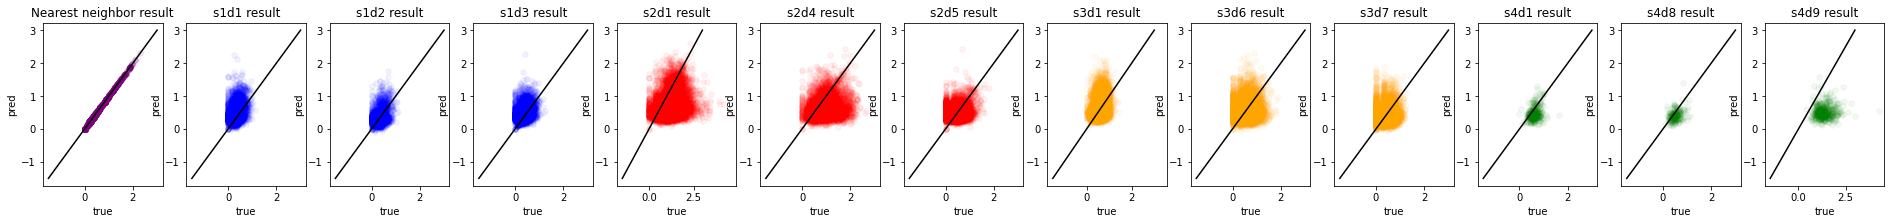

Epoch  27100 near loss: 0.0030306499 s1d1:  0.30042222 s1d2:  0.21519503 s1d3:  0.259325 s2d1: 0.72978693 s2d4: 0.5778397 s2d5: 0.3338829 s3d1: 0.3019051 s3d6: 0.37439856 s3d7: 0.31214193 s4d1: 0.26924706 s4d8: 0.28249973 s4d9: 0.9429986 test loss: 0.6699977035814491
Epoch  27200 near loss: 0.006335424 s1d1:  0.30422556 s1d2:  0.21695672 s1d3:  0.26248336 s2d1: 0.7253367 s2d4: 0.5747928 s2d5: 0.3363011 s3d1: 0.3033568 s3d6: 0.3756 s3d7: 0.31403372 s4d1: 0.26737982 s4d8: 0.28136367 s4d9: 0.9370873 test loss: 0.6658291329358832
Epoch  27300 near loss: 0.004811281 s1d1:  0.30290538 s1d2:  0.21638264 s1d3:  0.2614142 s2d1: 0.7258853 s2d4: 0.5752957 s2d5: 0.3360936 s3d1: 0.30270758 s3d6: 0.3752558 s3d7: 0.31364205 s4d1: 0.26741832 s4d8: 0.28136218 s4d9: 0.93807316 test loss: 0.6664710717410088
Epoch  27400 near loss: 0.00301871 s1d1:  0.29960972 s1d2:  0.21492332 s1d3:  0.25903165 s2d1: 0.7298261 s2d4: 0.5782881 s2d5: 0.33398697 s3d1: 0.30170587 s3d6: 0.3743066 s3d7: 0.3119856 s4d1: 0.26975

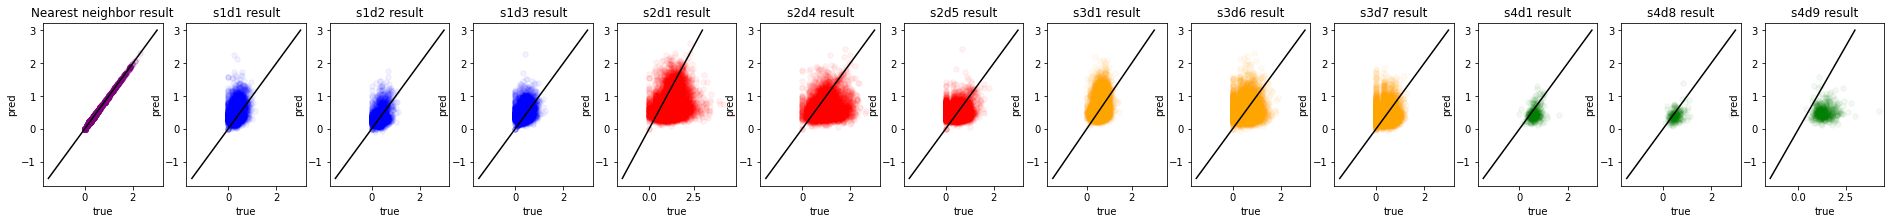

Epoch  28100 near loss: 0.003731946 s1d1:  0.30046076 s1d2:  0.21542853 s1d3:  0.2599045 s2d1: 0.73000044 s2d4: 0.57862675 s2d5: 0.33393803 s3d1: 0.30229774 s3d6: 0.37449032 s3d7: 0.31241554 s4d1: 0.27007443 s4d8: 0.28347826 s4d9: 0.94467753 test loss: 0.6712788601883333
Epoch  28200 near loss: 0.0047223694 s1d1:  0.30430228 s1d2:  0.21703 s1d3:  0.26289093 s2d1: 0.7256893 s2d4: 0.5752518 s2d5: 0.3359886 s3d1: 0.30314597 s3d6: 0.37540188 s3d7: 0.31391114 s4d1: 0.26800984 s4d8: 0.28193206 s4d9: 0.9386586 test loss: 0.6669784264771657
Epoch  28300 near loss: 0.006825248 s1d1:  0.2974516 s1d2:  0.21419683 s1d3:  0.2575416 s2d1: 0.7325358 s2d4: 0.58027494 s2d5: 0.3327152 s3d1: 0.30138034 s3d6: 0.3739189 s3d7: 0.31135023 s4d1: 0.27141935 s4d8: 0.28426743 s4d9: 0.94808096 test loss: 0.673727020097812
Epoch  28400 near loss: 0.004450224 s1d1:  0.30329937 s1d2:  0.21646842 s1d3:  0.26197577 s2d1: 0.72596985 s2d4: 0.57556266 s2d5: 0.3359498 s3d1: 0.30293918 s3d6: 0.37527928 s3d7: 0.31366578 s4d

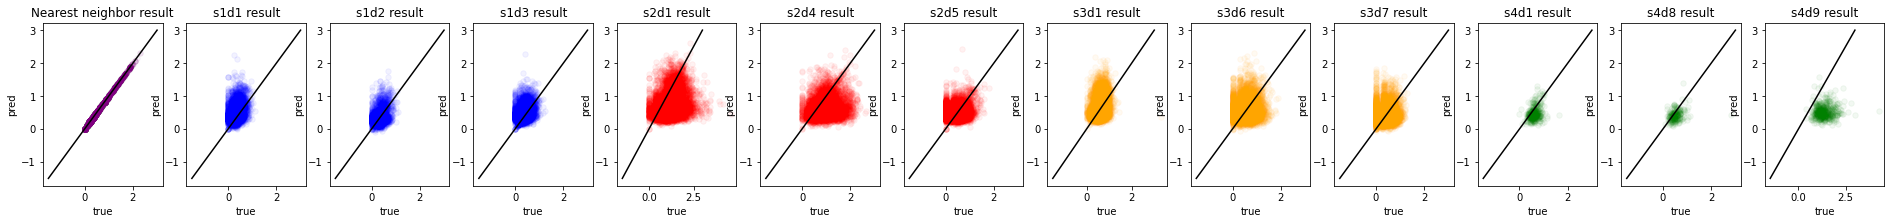

Epoch  29100 near loss: 0.010180857 s1d1:  0.2968253 s1d2:  0.21354544 s1d3:  0.25696626 s2d1: 0.73317593 s2d4: 0.5804493 s2d5: 0.33221117 s3d1: 0.30048767 s3d6: 0.37295076 s3d7: 0.31051612 s4d1: 0.2702171 s4d8: 0.28324717 s4d9: 0.9476202 test loss: 0.6731789225320145
Epoch  29200 near loss: 0.0023692744 s1d1:  0.30053264 s1d2:  0.21533997 s1d3:  0.26002535 s2d1: 0.7290816 s2d4: 0.5774411 s2d5: 0.33450207 s3d1: 0.30157012 s3d6: 0.3744396 s3d7: 0.31237352 s4d1: 0.26901007 s4d8: 0.2825185 s4d9: 0.94194686 test loss: 0.6692881059155636
Epoch  29300 near loss: 0.0024563808 s1d1:  0.30163124 s1d2:  0.21574296 s1d3:  0.2606068 s2d1: 0.7286337 s2d4: 0.5770217 s2d5: 0.33438003 s3d1: 0.3024308 s3d6: 0.37483 s3d7: 0.3127764 s4d1: 0.2688092 s4d8: 0.28241423 s4d9: 0.9418967 test loss: 0.669219620301284
Epoch  29400 near loss: 0.002465965 s1d1:  0.30006602 s1d2:  0.21528785 s1d3:  0.2596863 s2d1: 0.7298544 s2d4: 0.5783112 s2d5: 0.33425173 s3d1: 0.3016275 s3d6: 0.37444794 s3d7: 0.312237 s4d1: 0.2695

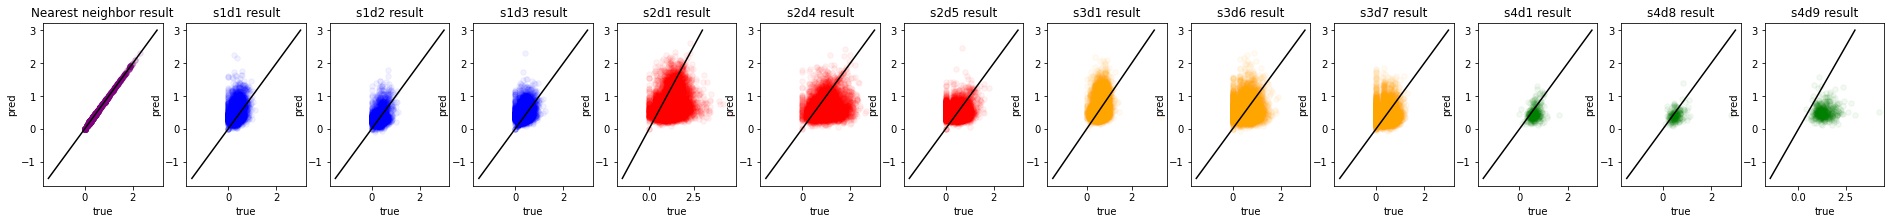

Epoch  30100 near loss: 0.0024029254 s1d1:  0.3020229 s1d2:  0.21614948 s1d3:  0.26122746 s2d1: 0.72810715 s2d4: 0.57730573 s2d5: 0.3351857 s3d1: 0.30167186 s3d6: 0.3748716 s3d7: 0.3128137 s4d1: 0.26899588 s4d8: 0.28268838 s4d9: 0.9412108 test loss: 0.6688255924212106
Epoch  30200 near loss: 0.0070686936 s1d1:  0.29754743 s1d2:  0.21409881 s1d3:  0.25790277 s2d1: 0.73166984 s2d4: 0.57964253 s2d5: 0.3329445 s3d1: 0.30080858 s3d6: 0.3733988 s3d7: 0.3111354 s4d1: 0.27011383 s4d8: 0.2832249 s4d9: 0.9461275 test loss: 0.6721986917958842
Epoch  30300 near loss: 0.002645075 s1d1:  0.30110717 s1d2:  0.21566342 s1d3:  0.26049346 s2d1: 0.7276363 s2d4: 0.5766811 s2d5: 0.33516353 s3d1: 0.30199417 s3d6: 0.3745569 s3d7: 0.31282344 s4d1: 0.26817742 s4d8: 0.28218347 s4d9: 0.9408865 test loss: 0.6684621220987653
Epoch  30400 near loss: 0.004071908 s1d1:  0.29861066 s1d2:  0.21464755 s1d3:  0.25859332 s2d1: 0.731068 s2d4: 0.5793624 s2d5: 0.33369043 s3d1: 0.30169937 s3d6: 0.37418255 s3d7: 0.31185046 s4d1

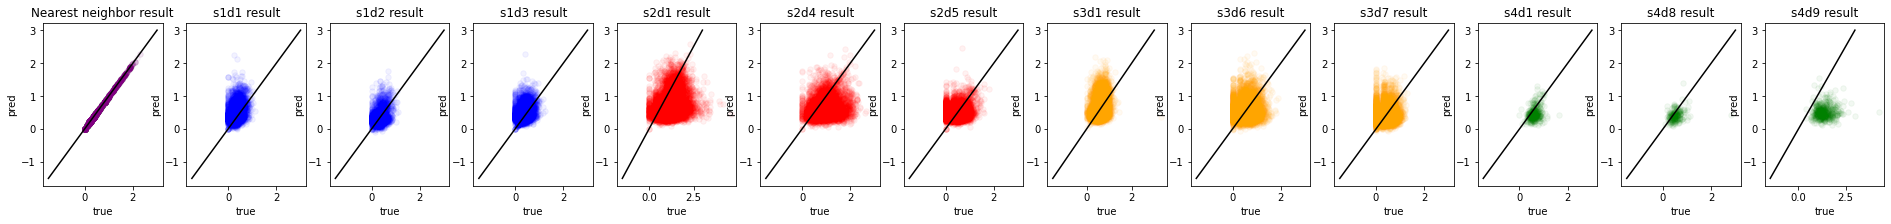

Epoch  31100 near loss: 0.004480281 s1d1:  0.30374533 s1d2:  0.21696725 s1d3:  0.26300645 s2d1: 0.72599125 s2d4: 0.5756518 s2d5: 0.33603337 s3d1: 0.30305088 s3d6: 0.37523597 s3d7: 0.3137047 s4d1: 0.26791468 s4d8: 0.281756 s4d9: 0.9386885 test loss: 0.6669695779311089
Epoch  31200 near loss: 0.0021089278 s1d1:  0.29982987 s1d2:  0.21513972 s1d3:  0.2594941 s2d1: 0.72919065 s2d4: 0.57769305 s2d5: 0.33439967 s3d1: 0.30129915 s3d6: 0.37421605 s3d7: 0.31220174 s4d1: 0.2688995 s4d8: 0.28262404 s4d9: 0.94243866 test loss: 0.6696001936982187
Epoch  31300 near loss: 0.0035586637 s1d1:  0.30253497 s1d2:  0.21627235 s1d3:  0.26190343 s2d1: 0.7272921 s2d4: 0.57639503 s2d5: 0.3353587 s3d1: 0.30270916 s3d6: 0.3750631 s3d7: 0.31314588 s4d1: 0.26835033 s4d8: 0.28206632 s4d9: 0.9392615 test loss: 0.6674253282242212
Epoch  31400 near loss: 0.0032011475 s1d1:  0.30107203 s1d2:  0.21554317 s1d3:  0.26062068 s2d1: 0.72716 s2d4: 0.5766308 s2d5: 0.33528876 s3d1: 0.302281 s3d6: 0.37459198 s3d7: 0.31275284 s4d

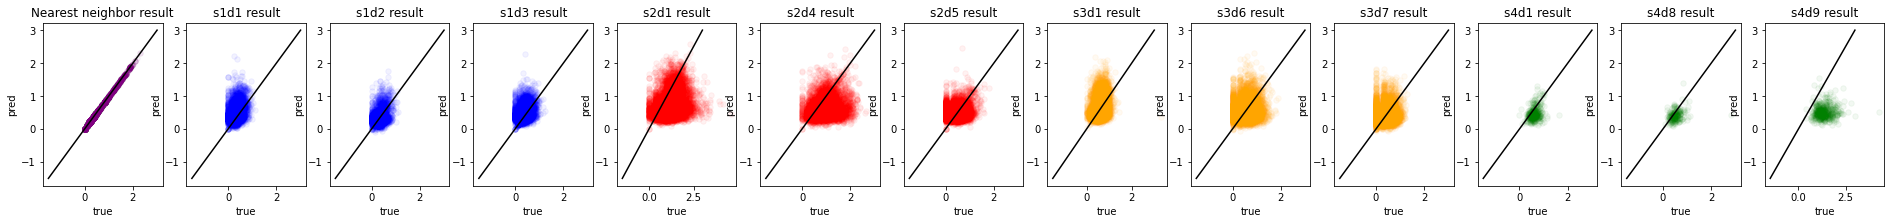

Epoch  32100 near loss: 0.0069114896 s1d1:  0.29831758 s1d2:  0.21449333 s1d3:  0.25865158 s2d1: 0.7321327 s2d4: 0.5801231 s2d5: 0.3329865 s3d1: 0.3009931 s3d6: 0.37369427 s3d7: 0.31121412 s4d1: 0.2705149 s4d8: 0.28373638 s4d9: 0.94612694 test loss: 0.6722968581611882
Epoch  32200 near loss: 0.002656022 s1d1:  0.30157945 s1d2:  0.21593834 s1d3:  0.26153517 s2d1: 0.72905993 s2d4: 0.5776 s2d5: 0.3345326 s3d1: 0.30210993 s3d6: 0.37432504 s3d7: 0.31239778 s4d1: 0.26890212 s4d8: 0.28265774 s4d9: 0.941855 test loss: 0.6692264516039033
Epoch  32300 near loss: 0.006461839 s1d1:  0.3034758 s1d2:  0.21663618 s1d3:  0.2625678 s2d1: 0.72529674 s2d4: 0.5753453 s2d5: 0.336675 s3d1: 0.3030784 s3d6: 0.37552541 s3d7: 0.31371167 s4d1: 0.26736012 s4d8: 0.28151417 s4d9: 0.9366951 test loss: 0.6655863188252145
Epoch  32400 near loss: 0.0039045124 s1d1:  0.30378184 s1d2:  0.21694712 s1d3:  0.26324892 s2d1: 0.7261862 s2d4: 0.5761374 s2d5: 0.33602265 s3d1: 0.302948 s3d6: 0.3752096 s3d7: 0.31343594 s4d1: 0.267

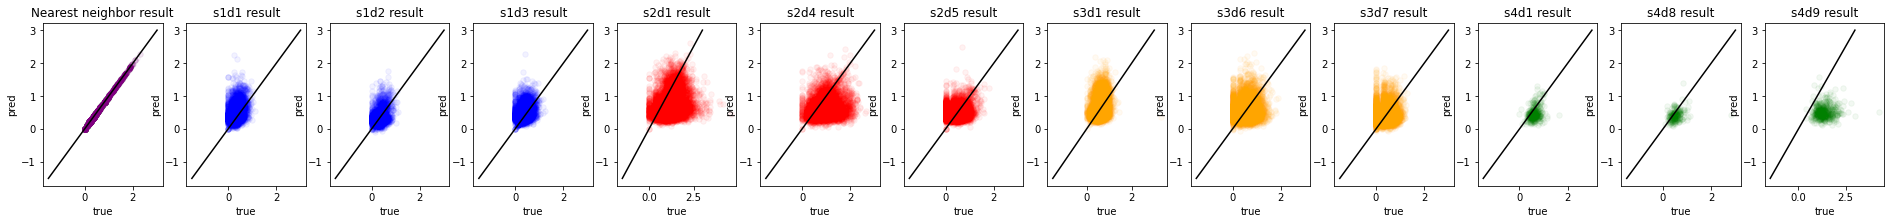

Epoch  33100 near loss: 0.0027099648 s1d1:  0.30076003 s1d2:  0.2152125 s1d3:  0.26041844 s2d1: 0.7286514 s2d4: 0.57753706 s2d5: 0.33459425 s3d1: 0.30186218 s3d6: 0.3745045 s3d7: 0.31231096 s4d1: 0.26882863 s4d8: 0.28238916 s4d9: 0.94191104 test loss: 0.6692293194513529
Epoch  33200 near loss: 0.0025337134 s1d1:  0.3021291 s1d2:  0.21611078 s1d3:  0.26165634 s2d1: 0.72855836 s2d4: 0.57713795 s2d5: 0.33496448 s3d1: 0.3023191 s3d6: 0.37498263 s3d7: 0.31289282 s4d1: 0.26891875 s4d8: 0.28259188 s4d9: 0.9409626 test loss: 0.6686464785951954
Epoch  33300 near loss: 0.0033475843 s1d1:  0.29961494 s1d2:  0.21498014 s1d3:  0.25978485 s2d1: 0.7289403 s2d4: 0.5770533 s2d5: 0.33457306 s3d1: 0.30039605 s3d6: 0.3737038 s3d7: 0.31187844 s4d1: 0.26813936 s4d8: 0.28217533 s4d9: 0.94103044 test loss: 0.6685493154474305
Epoch  33400 near loss: 0.002555557 s1d1:  0.30233166 s1d2:  0.21604878 s1d3:  0.26187596 s2d1: 0.7281477 s2d4: 0.57676655 s2d5: 0.33492923 s3d1: 0.30206728 s3d6: 0.37466684 s3d7: 0.31255

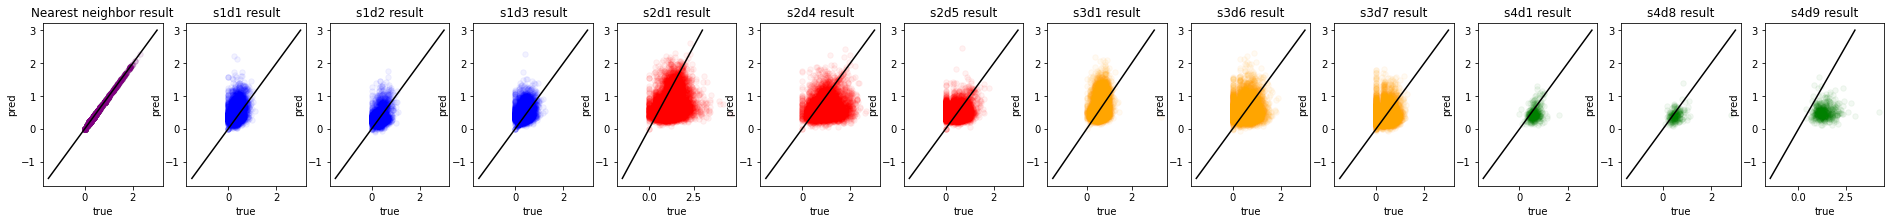

Epoch  34100 near loss: 0.0037914354 s1d1:  0.30274943 s1d2:  0.21638282 s1d3:  0.26230007 s2d1: 0.7272496 s2d4: 0.57636905 s2d5: 0.3356398 s3d1: 0.30197236 s3d6: 0.3750307 s3d7: 0.31299576 s4d1: 0.26824668 s4d8: 0.28207666 s4d9: 0.938974 test loss: 0.6672266172783448
Epoch  34200 near loss: 0.0023341235 s1d1:  0.30111682 s1d2:  0.21558295 s1d3:  0.26100597 s2d1: 0.728353 s2d4: 0.57717776 s2d5: 0.33486137 s3d1: 0.3012125 s3d6: 0.37436646 s3d7: 0.3124013 s4d1: 0.26884332 s4d8: 0.28257683 s4d9: 0.9411787 test loss: 0.6687745854557832
Epoch  34300 near loss: 0.0038179222 s1d1:  0.3003214 s1d2:  0.21512417 s1d3:  0.26023465 s2d1: 0.729308 s2d4: 0.578062 s2d5: 0.33425713 s3d1: 0.30153283 s3d6: 0.37399384 s3d7: 0.31197622 s4d1: 0.26862356 s4d8: 0.28233376 s4d9: 0.94256234 test loss: 0.6696177516028772
Epoch  34400 near loss: 0.002818326 s1d1:  0.30023664 s1d2:  0.21519585 s1d3:  0.2603895 s2d1: 0.72906935 s2d4: 0.5780011 s2d5: 0.33442816 s3d1: 0.30123737 s3d6: 0.37417468 s3d7: 0.3120436 s4d1

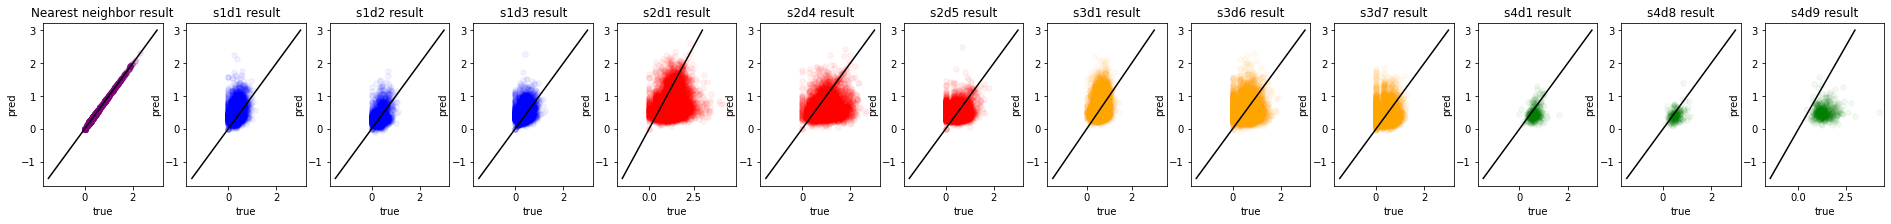

Epoch  35100 near loss: 0.004787736 s1d1:  0.3017653 s1d2:  0.2160198 s1d3:  0.26168695 s2d1: 0.7263196 s2d4: 0.57583606 s2d5: 0.33616722 s3d1: 0.3014907 s3d6: 0.37466168 s3d7: 0.3130341 s4d1: 0.26732174 s4d8: 0.28184828 s4d9: 0.9379968 test loss: 0.6664513047305952
Epoch  35200 near loss: 0.0035004392 s1d1:  0.30014658 s1d2:  0.21514441 s1d3:  0.26033533 s2d1: 0.72965527 s2d4: 0.57871544 s2d5: 0.33445212 s3d1: 0.30164093 s3d6: 0.37419492 s3d7: 0.31201234 s4d1: 0.26899812 s4d8: 0.28267395 s4d9: 0.9428889 test loss: 0.6699086641226862
Epoch  35300 near loss: 0.0025075406 s1d1:  0.3000521 s1d2:  0.21512383 s1d3:  0.26037237 s2d1: 0.72782123 s2d4: 0.57720846 s2d5: 0.33529422 s3d1: 0.3006436 s3d6: 0.37410548 s3d7: 0.3121899 s4d1: 0.2679593 s4d8: 0.2824365 s4d9: 0.94065166 test loss: 0.668303309518692
Epoch  35400 near loss: 0.0022170888 s1d1:  0.30042937 s1d2:  0.21534476 s1d3:  0.26046616 s2d1: 0.7290326 s2d4: 0.57762253 s2d5: 0.33469352 s3d1: 0.30102012 s3d6: 0.37417632 s3d7: 0.312129 s4

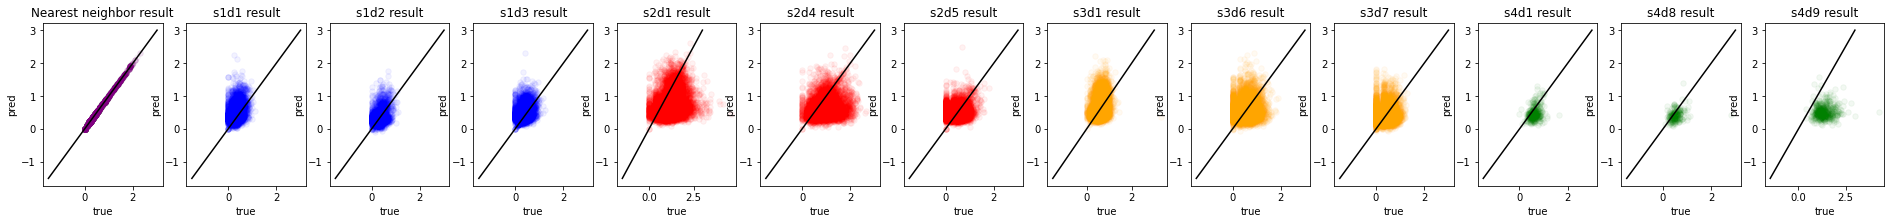

Epoch  36100 near loss: 0.003152108 s1d1:  0.30200002 s1d2:  0.21598668 s1d3:  0.26199928 s2d1: 0.7268938 s2d4: 0.57661664 s2d5: 0.33577874 s3d1: 0.30163178 s3d6: 0.37469232 s3d7: 0.31283706 s4d1: 0.26799753 s4d8: 0.28250563 s4d9: 0.9397218 test loss: 0.6677137937070823
Epoch  36200 near loss: 0.0034952157 s1d1:  0.30107638 s1d2:  0.2154426 s1d3:  0.26123124 s2d1: 0.7293163 s2d4: 0.5780808 s2d5: 0.33425906 s3d1: 0.30145854 s3d6: 0.37419677 s3d7: 0.3120471 s4d1: 0.26868552 s4d8: 0.2822467 s4d9: 0.94180286 test loss: 0.6691277898458247
Epoch  36300 near loss: 0.002980428 s1d1:  0.3015934 s1d2:  0.21584569 s1d3:  0.26162127 s2d1: 0.7272395 s2d4: 0.57678044 s2d5: 0.33577085 s3d1: 0.30151245 s3d6: 0.37466452 s3d7: 0.31277785 s4d1: 0.2680441 s4d8: 0.28238195 s4d9: 0.93943846 test loss: 0.6675261733251514
Epoch  36400 near loss: 0.0035080013 s1d1:  0.30008742 s1d2:  0.21517932 s1d3:  0.26052693 s2d1: 0.7303834 s2d4: 0.57853967 s2d5: 0.33381736 s3d1: 0.30106005 s3d6: 0.37386495 s3d7: 0.3116967

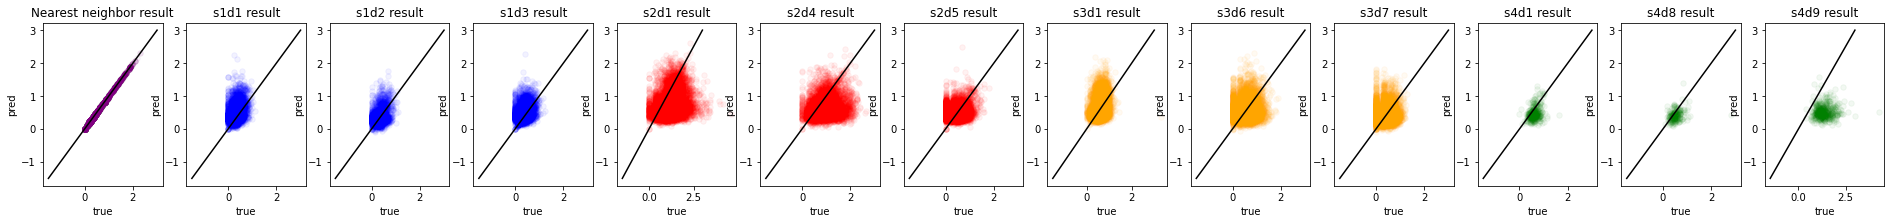

Epoch  37100 near loss: 0.004134965 s1d1:  0.2990569 s1d2:  0.21474744 s1d3:  0.2598034 s2d1: 0.73014635 s2d4: 0.57870525 s2d5: 0.33385205 s3d1: 0.3000031 s3d6: 0.3735124 s3d7: 0.31138614 s4d1: 0.26917163 s4d8: 0.28297645 s4d9: 0.9434797 test loss: 0.6703400451773757
Epoch  37200 near loss: 0.003160762 s1d1:  0.30182007 s1d2:  0.21591629 s1d3:  0.26205403 s2d1: 0.72684443 s2d4: 0.57610065 s2d5: 0.33568054 s3d1: 0.3010474 s3d6: 0.37415713 s3d7: 0.31267548 s4d1: 0.26729465 s4d8: 0.2819217 s4d9: 0.9386752 test loss: 0.6668924039146779
Epoch  37300 near loss: 0.006945546 s1d1:  0.2976701 s1d2:  0.21412246 s1d3:  0.2588175 s2d1: 0.73181415 s2d4: 0.57999456 s2d5: 0.33310667 s3d1: 0.29968923 s3d6: 0.37307057 s3d7: 0.31085303 s4d1: 0.2702939 s4d8: 0.28387237 s4d9: 0.9461567 test loss: 0.6722982592921201
Epoch  37400 near loss: 0.0085496195 s1d1:  0.30518204 s1d2:  0.21736288 s1d3:  0.264488 s2d1: 0.7233089 s2d4: 0.57427174 s2d5: 0.33769816 s3d1: 0.302907 s3d6: 0.3757423 s3d7: 0.31427377 s4d1: 

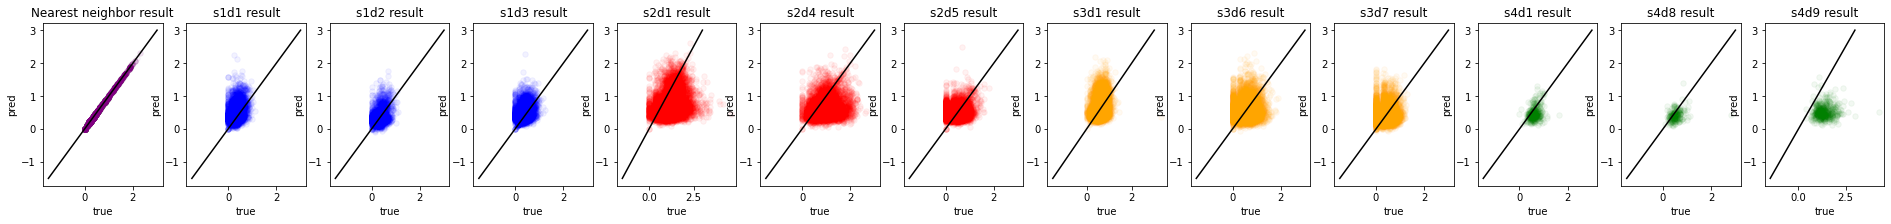

Epoch  38100 near loss: 0.0034098313 s1d1:  0.30177724 s1d2:  0.2160525 s1d3:  0.26204297 s2d1: 0.72655123 s2d4: 0.57631433 s2d5: 0.33595285 s3d1: 0.30092013 s3d6: 0.3743978 s3d7: 0.31278035 s4d1: 0.26736945 s4d8: 0.28201482 s4d9: 0.93822944 test loss: 0.6666225663303785
Epoch  38200 near loss: 0.0048109298 s1d1:  0.2989411 s1d2:  0.21483307 s1d3:  0.26006144 s2d1: 0.7293941 s2d4: 0.57799894 s2d5: 0.3342478 s3d1: 0.3000067 s3d6: 0.37305206 s3d7: 0.31134754 s4d1: 0.26831198 s4d8: 0.282621 s4d9: 0.9424812 test loss: 0.6695487063245469
Epoch  38300 near loss: 0.0020336295 s1d1:  0.3002817 s1d2:  0.21550953 s1d3:  0.26124358 s2d1: 0.7278694 s2d4: 0.5777165 s2d5: 0.33543104 s3d1: 0.30079088 s3d6: 0.37409824 s3d7: 0.31220552 s4d1: 0.26840708 s4d8: 0.28276998 s4d9: 0.94109625 test loss: 0.6686797102136959
Epoch  38400 near loss: 0.002526596 s1d1:  0.30055273 s1d2:  0.21541452 s1d3:  0.2611573 s2d1: 0.72818786 s2d4: 0.5776356 s2d5: 0.33492362 s3d1: 0.30110472 s3d6: 0.37403375 s3d7: 0.312153 s4

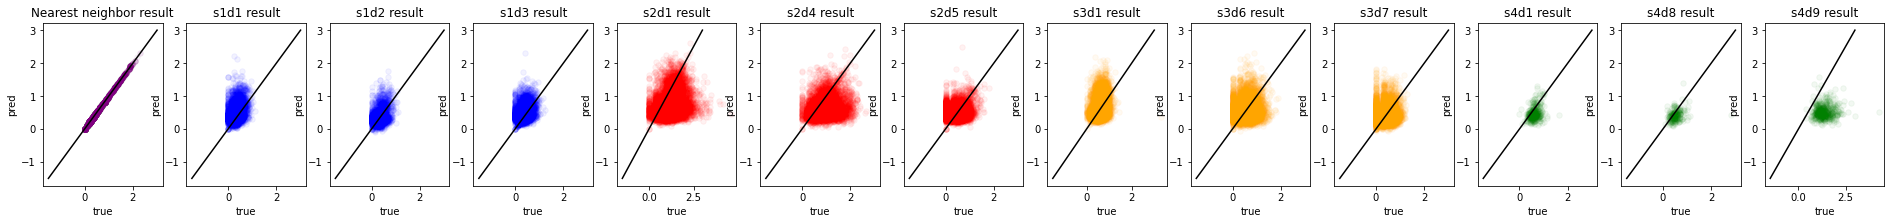

Epoch  39100 near loss: 0.004387893 s1d1:  0.29901376 s1d2:  0.21481828 s1d3:  0.26021925 s2d1: 0.7295275 s2d4: 0.5789634 s2d5: 0.33446825 s3d1: 0.30028206 s3d6: 0.37348863 s3d7: 0.3113405 s4d1: 0.26886898 s4d8: 0.28282118 s4d9: 0.9424308 test loss: 0.6696082446974811
Epoch  39200 near loss: 0.0021814601 s1d1:  0.3012372 s1d2:  0.21565048 s1d3:  0.26163945 s2d1: 0.728404 s2d4: 0.57744706 s2d5: 0.3349282 s3d1: 0.3009388 s3d6: 0.37424877 s3d7: 0.31227198 s4d1: 0.26859668 s4d8: 0.28249642 s4d9: 0.94041663 test loss: 0.6682421924102492
Epoch  39300 near loss: 0.0057554888 s1d1:  0.29980788 s1d2:  0.21502143 s1d3:  0.26060492 s2d1: 0.7306317 s2d4: 0.5793758 s2d5: 0.33349243 s3d1: 0.30069467 s3d6: 0.3734923 s3d7: 0.31147623 s4d1: 0.26952863 s4d8: 0.28305703 s4d9: 0.944149 test loss: 0.6708273566237212
Epoch  39400 near loss: 0.0020290036 s1d1:  0.30000773 s1d2:  0.2153888 s1d3:  0.2607158 s2d1: 0.72881347 s2d4: 0.5779886 s2d5: 0.33473235 s3d1: 0.300689 s3d6: 0.37388328 s3d7: 0.31203365 s4d1:

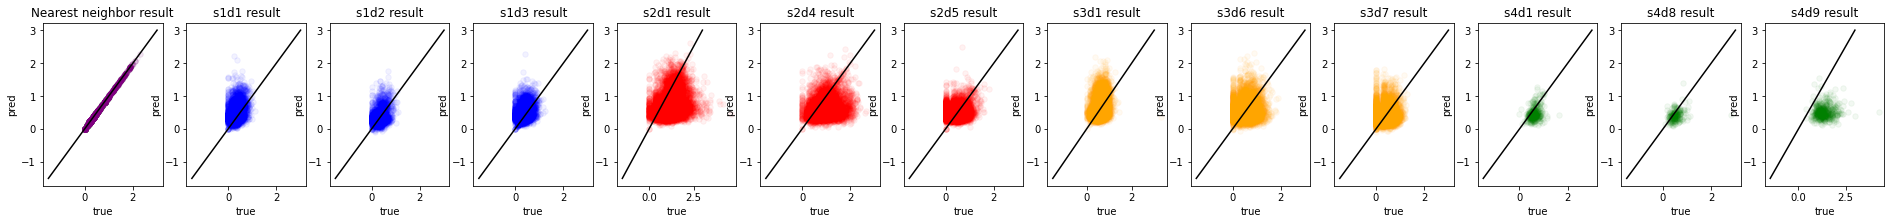

Epoch  40100 near loss: 0.004196471 s1d1:  0.3020995 s1d2:  0.2162328 s1d3:  0.26265052 s2d1: 0.7258185 s2d4: 0.5757019 s2d5: 0.33643126 s3d1: 0.30046934 s3d6: 0.37410837 s3d7: 0.31277445 s4d1: 0.2667516 s4d8: 0.28096753 s4d9: 0.9366203 test loss: 0.66540861388624
Epoch  40200 near loss: 0.003192522 s1d1:  0.29954967 s1d2:  0.21497291 s1d3:  0.26032314 s2d1: 0.7293599 s2d4: 0.57801324 s2d5: 0.33424574 s3d1: 0.29994917 s3d6: 0.37336585 s3d7: 0.3115192 s4d1: 0.26870716 s4d8: 0.2824657 s4d9: 0.94174707 test loss: 0.6691137789581394
Epoch  40300 near loss: 0.0024468226 s1d1:  0.30074143 s1d2:  0.21555078 s1d3:  0.261227 s2d1: 0.72732985 s2d4: 0.5768457 s2d5: 0.33550376 s3d1: 0.30032137 s3d6: 0.37396747 s3d7: 0.3122694 s4d1: 0.2678452 s4d8: 0.28207907 s4d9: 0.9394502 test loss: 0.6674805805454566
Epoch  40400 near loss: 0.003860516 s1d1:  0.30353245 s1d2:  0.2166454 s1d3:  0.2633986 s2d1: 0.72547024 s2d4: 0.5753811 s2d5: 0.33625486 s3d1: 0.301296 s3d6: 0.37458712 s3d7: 0.31310612 s4d1: 0.26

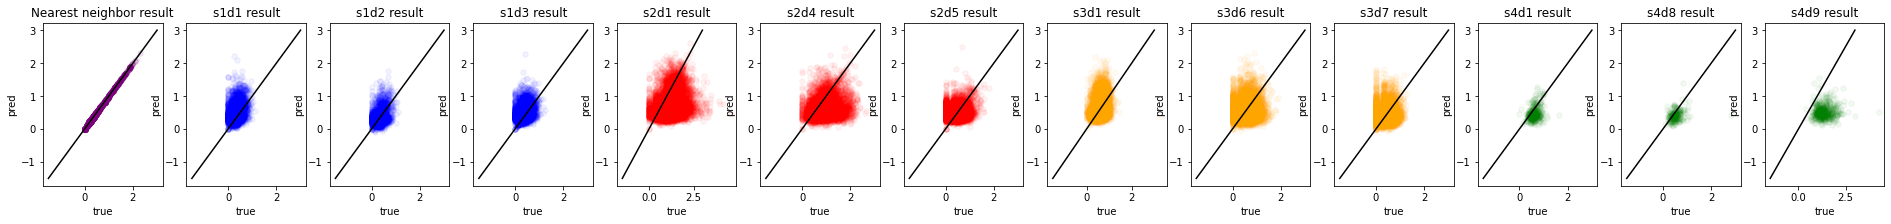

Epoch  41100 near loss: 0.002373405 s1d1:  0.3004777 s1d2:  0.2153138 s1d3:  0.26111764 s2d1: 0.7282665 s2d4: 0.57755244 s2d5: 0.3349703 s3d1: 0.30040294 s3d6: 0.3737968 s3d7: 0.3119677 s4d1: 0.26849064 s4d8: 0.28254455 s4d9: 0.94093436 test loss: 0.6685666238854276
Epoch  41200 near loss: 0.007620593 s1d1:  0.29750457 s1d2:  0.21409176 s1d3:  0.2589819 s2d1: 0.7319217 s2d4: 0.5804808 s2d5: 0.3331736 s3d1: 0.29945564 s3d6: 0.3730265 s3d7: 0.3107201 s4d1: 0.27010697 s4d8: 0.2837845 s4d9: 0.94601464 test loss: 0.6721737326536019
Epoch  41300 near loss: 0.003696092 s1d1:  0.3022751 s1d2:  0.21598735 s1d3:  0.26246652 s2d1: 0.7256045 s2d4: 0.57566804 s2d5: 0.33630556 s3d1: 0.30100062 s3d6: 0.37432694 s3d7: 0.3128195 s4d1: 0.26703227 s4d8: 0.28133065 s4d9: 0.9374541 test loss: 0.6660166347138031
Epoch  41400 near loss: 0.0033812237 s1d1:  0.2985623 s1d2:  0.21454792 s1d3:  0.25983727 s2d1: 0.7277792 s2d4: 0.5770185 s2d5: 0.3350941 s3d1: 0.29892406 s3d6: 0.37288713 s3d7: 0.31143722 s4d1: 0.2

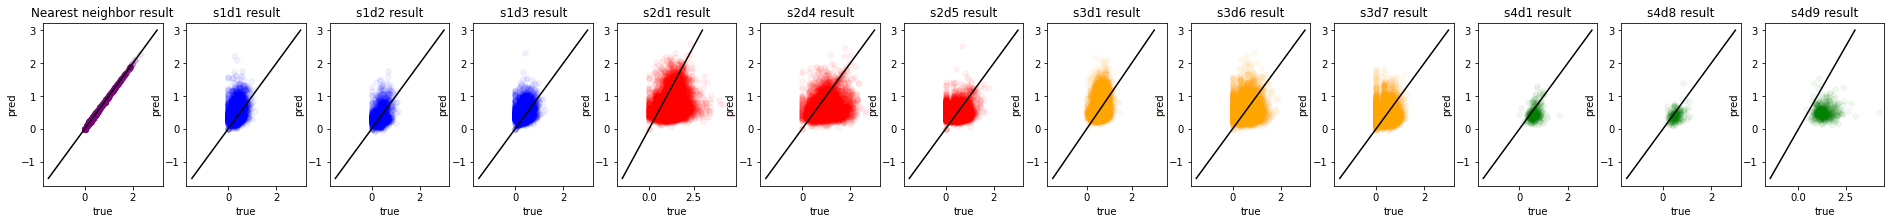

Epoch  42100 near loss: 0.002056969 s1d1:  0.3022762 s1d2:  0.21614324 s1d3:  0.26261318 s2d1: 0.72789025 s2d4: 0.577424 s2d5: 0.33524382 s3d1: 0.30117628 s3d6: 0.37455398 s3d7: 0.31265348 s4d1: 0.26858452 s4d8: 0.28246737 s4d9: 0.939437 test loss: 0.6676052378566624
Epoch  42200 near loss: 0.002826581 s1d1:  0.30033162 s1d2:  0.21536244 s1d3:  0.2612939 s2d1: 0.72749346 s2d4: 0.57681286 s2d5: 0.3354702 s3d1: 0.29970026 s3d6: 0.37370458 s3d7: 0.3121089 s4d1: 0.26757202 s4d8: 0.28192636 s4d9: 0.9386999 test loss: 0.6669458971674177
Epoch  42300 near loss: 0.004428212 s1d1:  0.29938102 s1d2:  0.21497478 s1d3:  0.26048478 s2d1: 0.7292404 s2d4: 0.5787526 s2d5: 0.33438677 s3d1: 0.3001496 s3d6: 0.3735066 s3d7: 0.31157276 s4d1: 0.26913673 s4d8: 0.28312564 s4d9: 0.9426407 test loss: 0.66980639948865
Epoch  42400 near loss: 0.002870833 s1d1:  0.2999307 s1d2:  0.21504027 s1d3:  0.2607518 s2d1: 0.72862583 s2d4: 0.5780325 s2d5: 0.33484548 s3d1: 0.29991964 s3d6: 0.37358722 s3d7: 0.31180528 s4d1: 0.

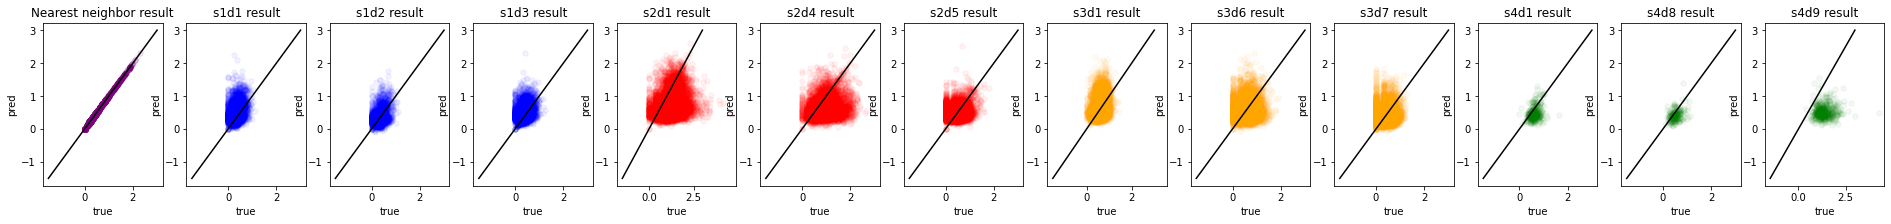

Epoch  43100 near loss: 0.006824327 s1d1:  0.30538106 s1d2:  0.21743903 s1d3:  0.26518735 s2d1: 0.72368544 s2d4: 0.57475895 s2d5: 0.33731484 s3d1: 0.301815 s3d6: 0.3753241 s3d7: 0.3140117 s4d1: 0.26650554 s4d8: 0.2808799 s4d9: 0.9336707 test loss: 0.6634625042764254
Epoch  43200 near loss: 0.0021460599 s1d1:  0.3015431 s1d2:  0.2156967 s1d3:  0.26207075 s2d1: 0.7279284 s2d4: 0.577544 s2d5: 0.33499792 s3d1: 0.30057147 s3d6: 0.37425488 s3d7: 0.31231347 s4d1: 0.26826897 s4d8: 0.2824727 s4d9: 0.94005966 test loss: 0.6679655534377771
Epoch  43300 near loss: 0.0020498459 s1d1:  0.30088705 s1d2:  0.21556348 s1d3:  0.2618108 s2d1: 0.7280973 s2d4: 0.57748777 s2d5: 0.3349787 s3d1: 0.30014017 s3d6: 0.37387747 s3d7: 0.31211203 s4d1: 0.26836914 s4d8: 0.2824413 s4d9: 0.9403718 test loss: 0.6681778859345208
Epoch  43400 near loss: 0.0025321057 s1d1:  0.30239594 s1d2:  0.21622683 s1d3:  0.26305634 s2d1: 0.7264293 s2d4: 0.5767019 s2d5: 0.33590627 s3d1: 0.30075815 s3d6: 0.37441358 s3d7: 0.3128002 s4d1: 

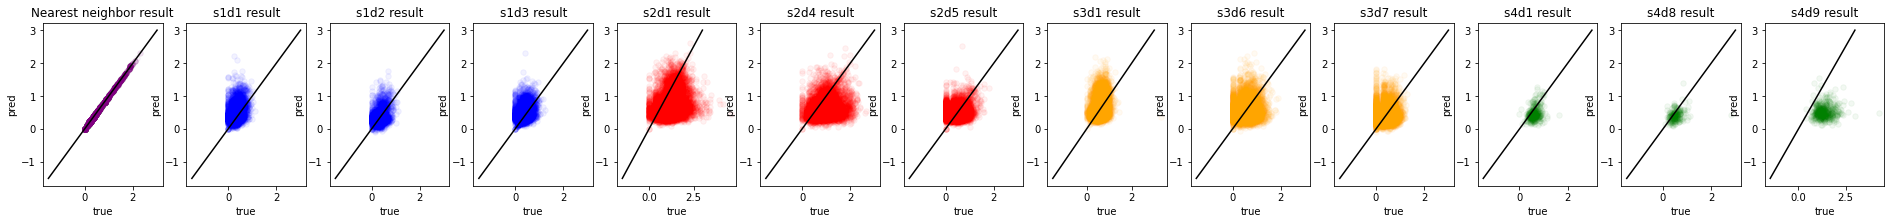

Epoch  44100 near loss: 0.0064539956 s1d1:  0.29897135 s1d2:  0.21490511 s1d3:  0.26043397 s2d1: 0.73061305 s2d4: 0.57908 s2d5: 0.33343092 s3d1: 0.2995052 s3d6: 0.37318367 s3d7: 0.31125364 s4d1: 0.26983607 s4d8: 0.28343883 s4d9: 0.9441207 test loss: 0.6708837147836654
Epoch  44200 near loss: 0.003878101 s1d1:  0.3016711 s1d2:  0.21601237 s1d3:  0.26251987 s2d1: 0.72511744 s2d4: 0.5755183 s2d5: 0.3368863 s3d1: 0.30020064 s3d6: 0.37413245 s3d7: 0.31284297 s4d1: 0.26666132 s4d8: 0.2812978 s4d9: 0.9359307 test loss: 0.664979912932455
Epoch  44300 near loss: 0.0041338922 s1d1:  0.2994173 s1d2:  0.21489221 s1d3:  0.26065233 s2d1: 0.7293386 s2d4: 0.5780647 s2d5: 0.3343611 s3d1: 0.29970375 s3d6: 0.37328097 s3d7: 0.3115186 s4d1: 0.26832905 s4d8: 0.28219807 s4d9: 0.9411762 test loss: 0.6686708729492766
Epoch  44400 near loss: 0.0025025217 s1d1:  0.30162624 s1d2:  0.21572965 s1d3:  0.26203611 s2d1: 0.7277826 s2d4: 0.5772523 s2d5: 0.33495426 s3d1: 0.30090323 s3d6: 0.3741552 s3d7: 0.31235617 s4d1: 

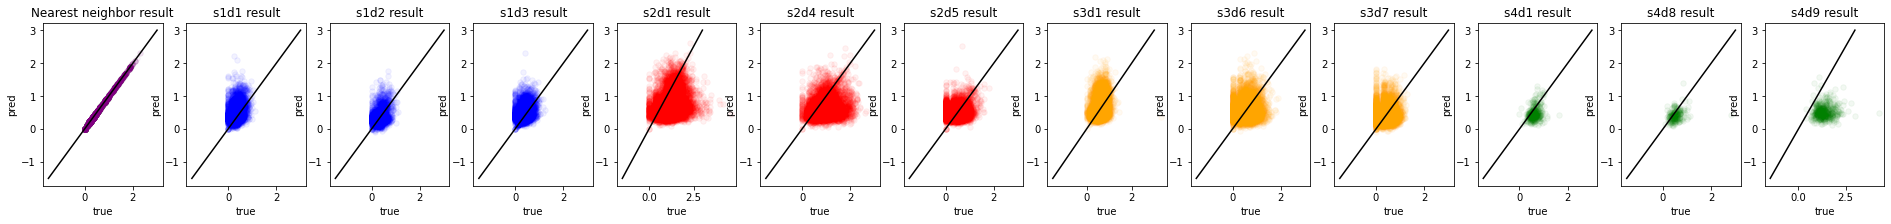

Epoch  45100 near loss: 0.002045202 s1d1:  0.3007278 s1d2:  0.21538626 s1d3:  0.26126093 s2d1: 0.7270088 s2d4: 0.5768884 s2d5: 0.33553424 s3d1: 0.29974717 s3d6: 0.37387607 s3d7: 0.31227818 s4d1: 0.26748312 s4d8: 0.28184605 s4d9: 0.93853116 test loss: 0.6668179363439773
Epoch  45200 near loss: 0.0076297363 s1d1:  0.30489233 s1d2:  0.21724635 s1d3:  0.2647988 s2d1: 0.72371095 s2d4: 0.5747641 s2d5: 0.337601 s3d1: 0.30152577 s3d6: 0.37538493 s3d7: 0.31394312 s4d1: 0.26647818 s4d8: 0.28100783 s4d9: 0.9339436 test loss: 0.6636463245909352
Epoch  45300 near loss: 0.002811432 s1d1:  0.30177647 s1d2:  0.21585254 s1d3:  0.262227 s2d1: 0.72884566 s2d4: 0.5781623 s2d5: 0.33463085 s3d1: 0.30065742 s3d6: 0.37425444 s3d7: 0.31228048 s4d1: 0.26867396 s4d8: 0.28245854 s4d9: 0.9408072 test loss: 0.6685015652007145
Epoch  45400 near loss: 0.0033305653 s1d1:  0.30035344 s1d2:  0.21509954 s1d3:  0.26099116 s2d1: 0.72919124 s2d4: 0.5788634 s2d5: 0.33453283 s3d1: 0.3002046 s3d6: 0.37389556 s3d7: 0.31174883 s

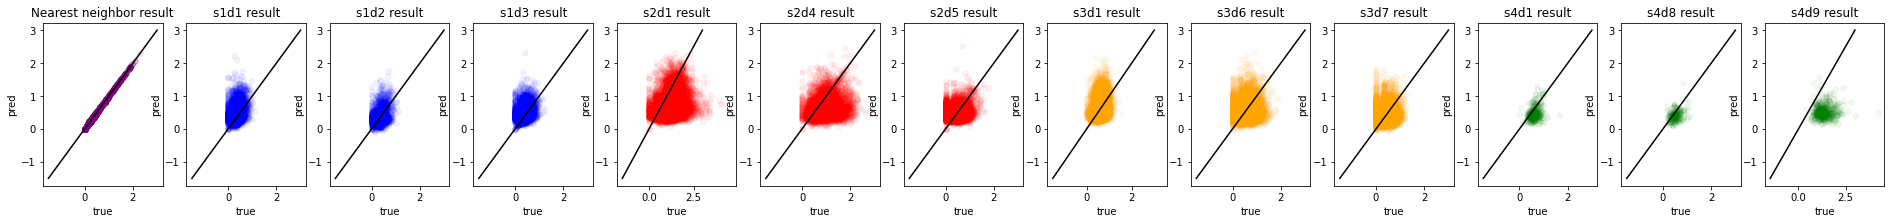

Epoch  46100 near loss: 0.0034297777 s1d1:  0.3027624 s1d2:  0.21621926 s1d3:  0.2630908 s2d1: 0.72621757 s2d4: 0.57631946 s2d5: 0.33598724 s3d1: 0.3003038 s3d6: 0.3744947 s3d7: 0.31299603 s4d1: 0.26730186 s4d8: 0.28158557 s4d9: 0.93676716 test loss: 0.6656313049438668
Epoch  46200 near loss: 0.0037718273 s1d1:  0.29986295 s1d2:  0.21499899 s1d3:  0.26101175 s2d1: 0.7295857 s2d4: 0.5788628 s2d5: 0.33429554 s3d1: 0.2998556 s3d6: 0.37369263 s3d7: 0.31162697 s4d1: 0.26904386 s4d8: 0.28268427 s4d9: 0.94196624 test loss: 0.6693196400844762
Epoch  46300 near loss: 0.002572433 s1d1:  0.30172583 s1d2:  0.21572033 s1d3:  0.26237738 s2d1: 0.72671556 s2d4: 0.57646024 s2d5: 0.3354584 s3d1: 0.2998742 s3d6: 0.37375945 s3d7: 0.3123404 s4d1: 0.26711217 s4d8: 0.28120682 s4d9: 0.9373261 test loss: 0.6659337957459083
Epoch  46400 near loss: 0.0031088647 s1d1:  0.30257455 s1d2:  0.21613754 s1d3:  0.26329035 s2d1: 0.7262715 s2d4: 0.5765389 s2d5: 0.33602914 s3d1: 0.30074143 s3d6: 0.37444705 s3d7: 0.31285486

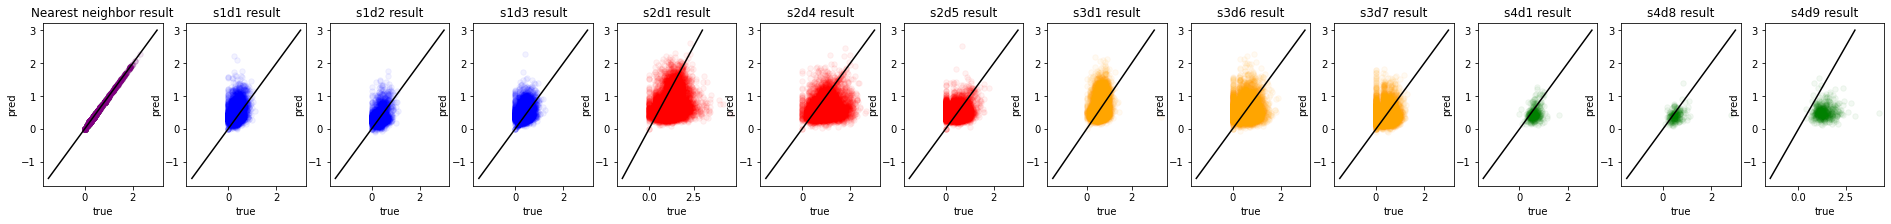

Epoch  47100 near loss: 0.0022425207 s1d1:  0.30209604 s1d2:  0.21599685 s1d3:  0.26267564 s2d1: 0.7275393 s2d4: 0.5773184 s2d5: 0.3351803 s3d1: 0.3009732 s3d6: 0.37437373 s3d7: 0.31249562 s4d1: 0.2681891 s4d8: 0.28204873 s4d9: 0.9390451 test loss: 0.6672623448860165
Epoch  47200 near loss: 0.0046786796 s1d1:  0.3000135 s1d2:  0.21508735 s1d3:  0.261067 s2d1: 0.7286329 s2d4: 0.5780895 s2d5: 0.334588 s3d1: 0.29902592 s3d6: 0.3732824 s3d7: 0.3114916 s4d1: 0.26837897 s4d8: 0.28231728 s4d9: 0.94048125 test loss: 0.6682390464984957
Epoch  47300 near loss: 0.0029991737 s1d1:  0.30008507 s1d2:  0.2152081 s1d3:  0.26118568 s2d1: 0.72810596 s2d4: 0.5776376 s2d5: 0.33500245 s3d1: 0.29919663 s3d6: 0.37354618 s3d7: 0.31183192 s4d1: 0.26813623 s4d8: 0.28224564 s4d9: 0.93979394 test loss: 0.6677562362684697
Epoch  47400 near loss: 0.002287008 s1d1:  0.30118284 s1d2:  0.21558096 s1d3:  0.26213992 s2d1: 0.7269527 s2d4: 0.5772886 s2d5: 0.3357945 s3d1: 0.2997868 s3d6: 0.37403947 s3d7: 0.31235248 s4d1: 0

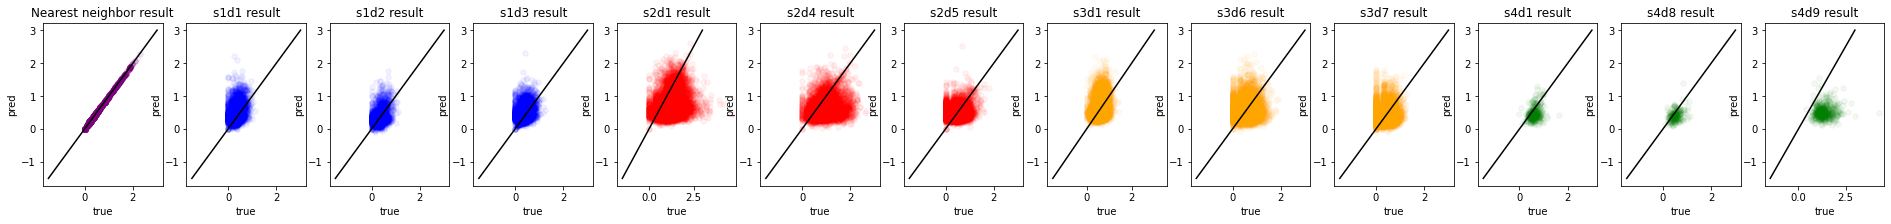

Epoch  48100 near loss: 0.0024636157 s1d1:  0.30117324 s1d2:  0.21550459 s1d3:  0.26226982 s2d1: 0.7265521 s2d4: 0.5766176 s2d5: 0.33569494 s3d1: 0.29971603 s3d6: 0.373658 s3d7: 0.31225076 s4d1: 0.26731053 s4d8: 0.28158957 s4d9: 0.9378563 test loss: 0.6663364122139062
Epoch  48200 near loss: 0.0020678316 s1d1:  0.30161518 s1d2:  0.21584593 s1d3:  0.26263762 s2d1: 0.727012 s2d4: 0.5767516 s2d5: 0.33559304 s3d1: 0.29947236 s3d6: 0.37379795 s3d7: 0.31232148 s4d1: 0.26742142 s4d8: 0.28153965 s4d9: 0.937722 test loss: 0.6662601474077327
Epoch  48300 near loss: 0.0021278295 s1d1:  0.30043393 s1d2:  0.215247 s1d3:  0.26162258 s2d1: 0.7276104 s2d4: 0.57762206 s2d5: 0.33529678 s3d1: 0.29920602 s3d6: 0.37366638 s3d7: 0.3119536 s4d1: 0.26842394 s4d8: 0.28259227 s4d9: 0.9396534 test loss: 0.6677344000229318
Epoch  48400 near loss: 0.0025326433 s1d1:  0.30080432 s1d2:  0.21520099 s1d3:  0.26173413 s2d1: 0.7276655 s2d4: 0.5768938 s2d5: 0.33502683 s3d1: 0.29945427 s3d6: 0.37358332 s3d7: 0.31197077 s4

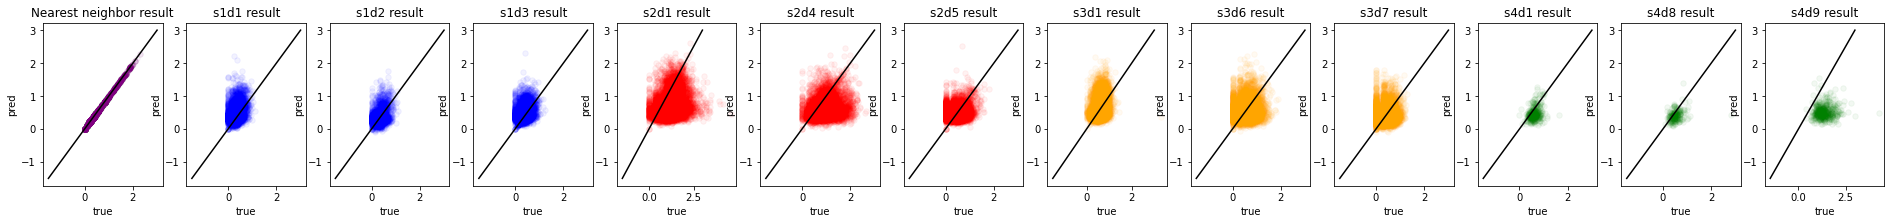

Epoch  49100 near loss: 0.0021787724 s1d1:  0.3004462 s1d2:  0.2152807 s1d3:  0.2615573 s2d1: 0.7278357 s2d4: 0.5773565 s2d5: 0.3348719 s3d1: 0.29940075 s3d6: 0.37365833 s3d7: 0.31188968 s4d1: 0.26792622 s4d8: 0.282095 s4d9: 0.93916893 test loss: 0.6673111312815017
Epoch  49200 near loss: 0.0022743363 s1d1:  0.30168962 s1d2:  0.21569824 s1d3:  0.26248088 s2d1: 0.7267343 s2d4: 0.5769945 s2d5: 0.3355247 s3d1: 0.30042565 s3d6: 0.37418723 s3d7: 0.31244272 s4d1: 0.26776794 s4d8: 0.2819212 s4d9: 0.9378717 test loss: 0.6664367074759142
Epoch  49300 near loss: 0.004529155 s1d1:  0.3042341 s1d2:  0.21697867 s1d3:  0.26468793 s2d1: 0.72487754 s2d4: 0.5756183 s2d5: 0.3365801 s3d1: 0.3006642 s3d6: 0.3749174 s3d7: 0.31347853 s4d1: 0.26730013 s4d8: 0.28128853 s4d9: 0.93499696 test loss: 0.6644616276893898
Epoch  49400 near loss: 0.005918641 s1d1:  0.3041448 s1d2:  0.2167553 s1d3:  0.2644163 s2d1: 0.7235496 s2d4: 0.5746154 s2d5: 0.33744377 s3d1: 0.3002152 s3d6: 0.37479752 s3d7: 0.31345555 s4d1: 0.266

In [41]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)